In [2]:
#library building
import networkx as nx
import math
import numpy as np
import random as rand
import copy
#%matplotlib inline
import matplotlib.pyplot as plt
from itertools import combinations as comb
#constants
SEED= 42

In [3]:
#**** Graph building helper functions ****#

#degree k, rewiring probability p
def get_watts_strogatz_graph(nodeNum,k,p):   
    G = nx.watts_strogatz_graph(nodeNum,k,p,seed=SEED)
    for e in G.edges():
        G[e[0]][e[1]]['weight'] = 1
    return G

# Build g
def get_undirected_ER_graph(nodeNum, p):
    G = nx.erdos_renyi_graph(nodeNum,p,seed=SEED)
    for e in G.edges():
        G[e[0]][e[1]]['weight'] = 1
    return G

#Generate tree with powerlaw degree distribution
def get_powerlaw_tree_graph(nodeNum,gamma):
    G = nx.random_powerlaw_tree(nodeNum,gamma,seed=SEED)
    for e in G.edges():
        G[e[0]][e[1]]['weight'] = 1
    return G


In [4]:
#Graph helper functions

def draw_graph_helper(H,positionFlag="spring",drawNodeLabels=True,drawEdgeLabels=False,pos=None):
    
    if (positionFlag.startswith("spring") and pos==None):
        pos=nx.spring_layout(H,iterations=20)
    if (positionFlag.startswith("random") and pos==None):
        pos=nx.random_layout(H)
    plt.figure(figsize=(20,20))
    
    nx.draw_networkx_nodes(H,pos)
    nx.draw_networkx_edges(H,pos)
    if (drawNodeLabels):
        nx.draw_networkx_labels(H,pos,fontsize=12)
    
    labels = nx.get_edge_attributes(H,'weight')
    labelsNonZero = {}
    for l in labels.keys():
        if labels[l] > 0.0001:
            labelsNonZero[l] = labels[l]
            
    if (drawEdgeLabels):
        nx.draw_networkx_edge_labels(H,pos,edge_labels=labelsNonZero)
    
    plt.show()
    return pos

Watts Strogatz Ring (no rewiring)


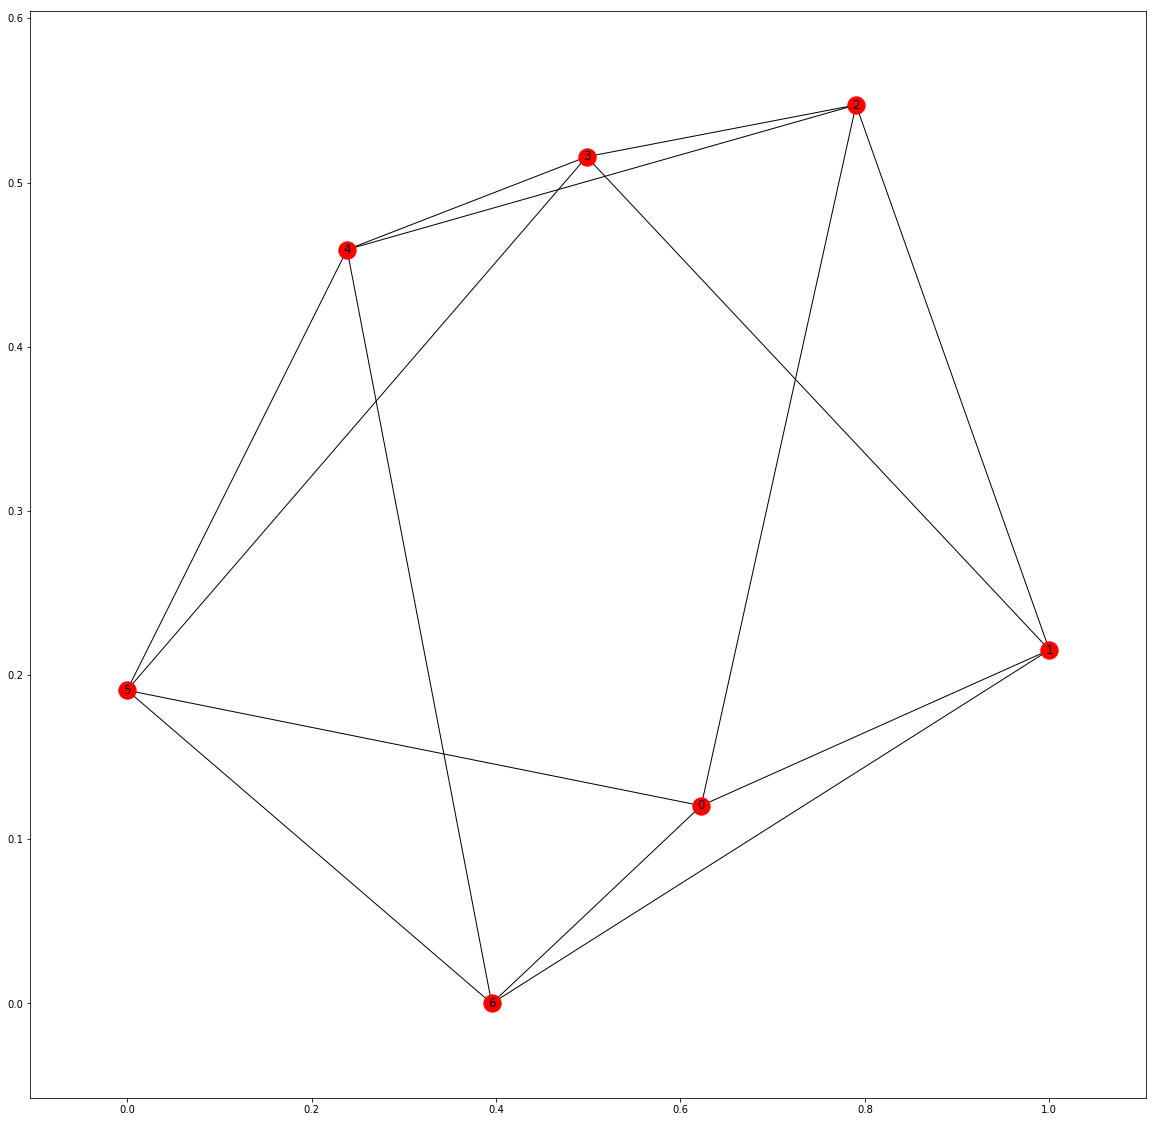

ER graph, p=0.3


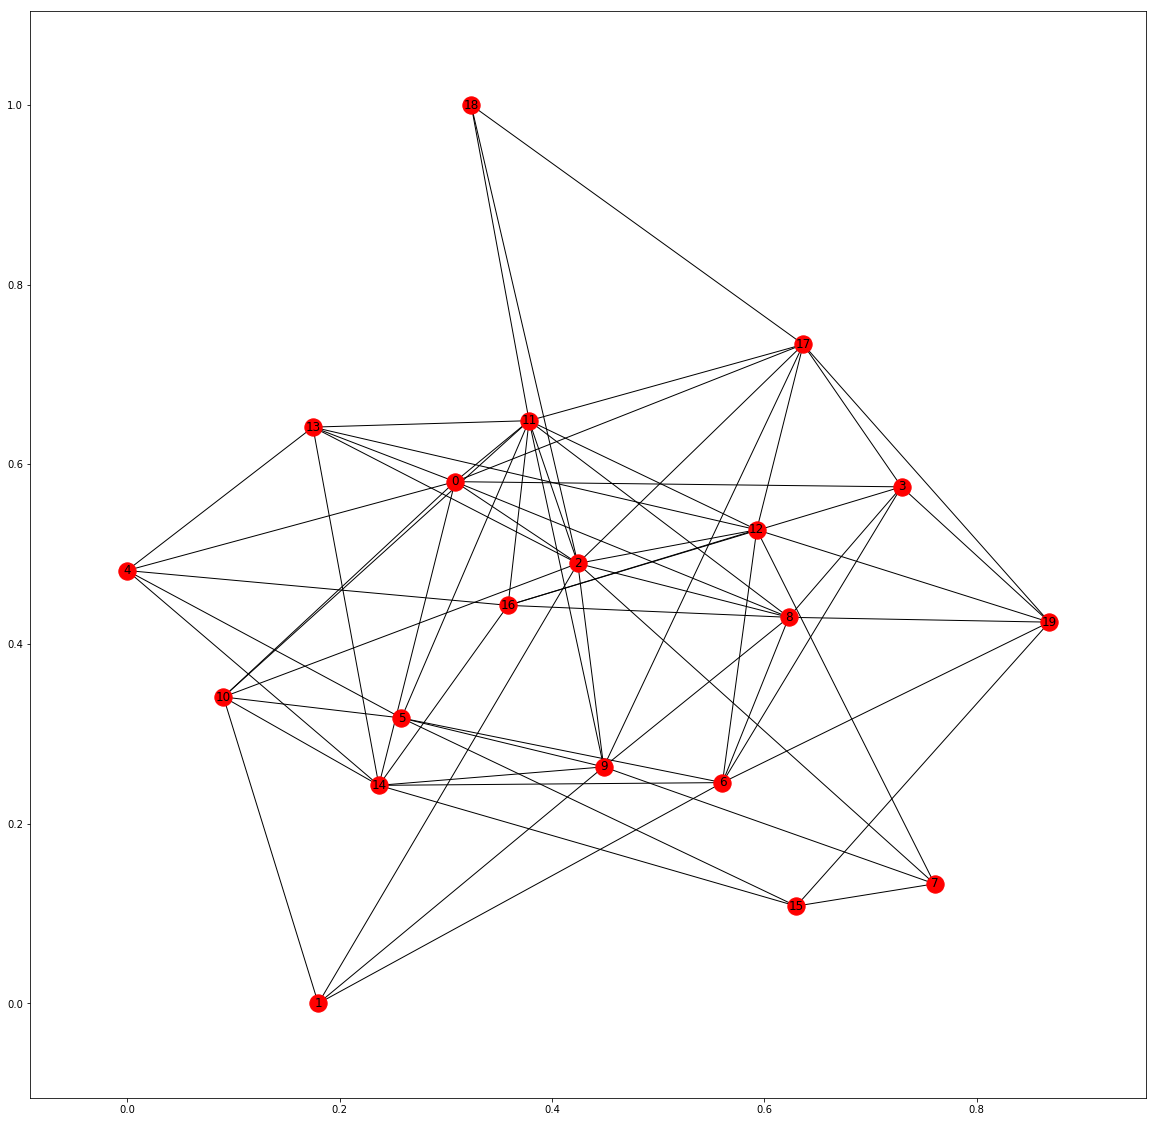

Powerlaw tree, gamma= 3


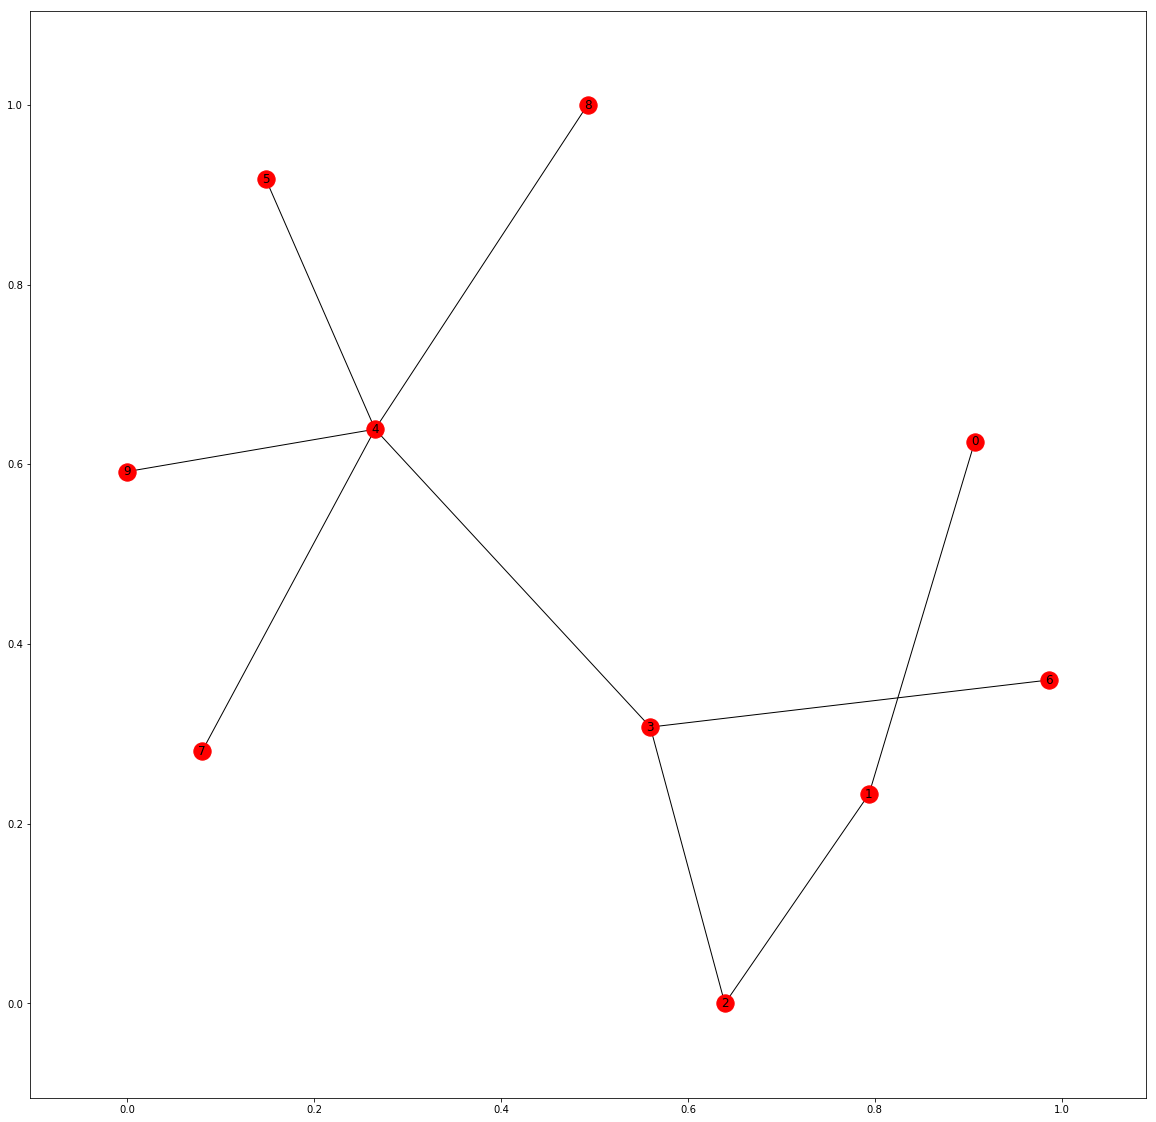

{0: array([ 0.90689776,  0.62527038]),
 1: array([ 0.79371727,  0.23290239]),
 2: array([ 0.63956014,  0.        ]),
 3: array([ 0.55982613,  0.30757539]),
 4: array([ 0.26533303,  0.63910315]),
 5: array([ 0.14854635,  0.91716727]),
 6: array([ 0.98671869,  0.36005796]),
 7: array([ 0.08017227,  0.28061509]),
 8: array([ 0.49266289,  1.        ]),
 9: array([ 0.        ,  0.59191031])}

In [5]:
#Quick test of all graph generators
print "Watts Strogatz Ring (no rewiring)"
WS1 = get_watts_strogatz_graph(7,4,0.0)
draw_graph_helper(WS1,"spring")
print "ER graph, p=0.3"
draw_graph_helper(get_undirected_ER_graph(20,0.3),"spring")
print "Powerlaw tree, gamma= 3"
PLTREE1 = get_powerlaw_tree_graph(10,3)
draw_graph_helper(PLTREE1,"spring")



In [6]:
#Construct a graph whose edge weights are the likelihood of an awareness relationship, given the contact graph G
#under the JS spline metric model
# --> This is a symetric measure,for unweighted graphs 
def construct_awareness_from_contact_graph(G):
    H = G.copy()
    #print "Edges",H.edges()
    for pair in comb(G.nodes(),2): #get pairs
        x = pair[0]
        y = pair[1]
       
        metric = 0.0
        if (y in G[x].keys()):#if y a neighor of x (and visa versa)
            metric = 0.5
            
        #JS Metric
        xNbr = set(G[x])
        yNbr = set(G[y])
        
        #if they have no mutual neighbors
        if (len(xNbr) == 0 and len(yNbr) == 0):
            H.add_edge(x,y,weight=metric)
            continue
            
        mutualNbrs = xNbr.intersection(yNbr)
        
        #special case of isolated dyad
        if (xNbr == set([y]) and yNbr == set([x])):
            metric = 1.0
        else:
            metric = metric + len(mutualNbrs)/float(len(xNbr.union(yNbr)))
        
        #set as edge weight in new graph
        if (y not in H[x]):
            H.add_edge(x,y)
        H[x][y]['weight'] = metric
        
    return H
        
    

In [7]:
#Calculate the expected number of neighbors of S in nodeSet, not including S itself
def get_exp_coverage(G,nodeSet,S):
    #Coverage probabilities of
    #print "Finding coverage of S = ",S
    covg = {}
    
    for n in S:
        #Get neighbors
        for b in G[n]:
            #If not in nodeSet or in S, ignore
            if (b not in nodeSet or b in S):
                continue
            #If in nodeSet and already covered by some node, update coverage
            elif (b in covg.keys()): 
                #Update coverage of b
                covg[b] = 1 - (1-covg[b])*(1-G[n][b]['weight'])
            else:
                covg[b] = G[n][b]['weight']
                
    #return the sum of all of the coverage weights
    return sum([covg[x] for x in covg.keys()])
    
# Find approximation max coverage set using k-greedy method, with t total nodes in solution
def greedy_expected_max_coverage_set(G,t,k):
    #Debug
    #assert(t < len(G.nodes()))
    
        #solution
    soln = set()
           
    #node set
    remaining_nodes = set(G.nodes())
    
    #Construct how many nodes to select at each step
    k_vals = [k for _ in range(int(math.floor(float(t)/k)))]
    if (t - sum(k_vals) > 0):
        k_vals.append(t - sum(k_vals))
    #Debug
    #assert(sum(k_vals) == t)
    
    for sub_k in k_vals:
        
        #Get value of current (partial solution)
        if (len(soln) > 0):
            current_covg = get_exp_coverage(G,G.nodes(),soln)
        else:
            current_covg = 0.0
           
        max_sym_diff = 0.0
        best_seen_soln = set()
        remaining_nodes = remaining_nodes.difference(soln)
        
        #print "\n Selecting next ", sub_k, "nodes from set ", remaining_nodes
        for nodeset in comb(remaining_nodes,sub_k): #For all k combinations of unselected nodes
            #calculate expected coverage with the addition of nodeset to the current solution
            sym_diff = get_exp_coverage(G,G.nodes(),soln.union(nodeset))
            #print "Coverage of ", soln.union(nodeset), "is ", sym_diff
            if (sym_diff > max_sym_diff):
                #print "Using ", nodeset, "as current best"
                max_sym_diff = sym_diff
                best_seen_soln = nodeset
        #print "Chose node(s) ", list(best_seen_soln)
        #Add found nodes to solution set
        #Debug
        #assert(len(set(best_seen_soln).intersection(soln)) == 0)
        soln = soln.union(set(best_seen_soln))
        
    #Return coverage plus the number of committee members
    return soln,(max_sym_diff+t)

Power law tree awareness graph


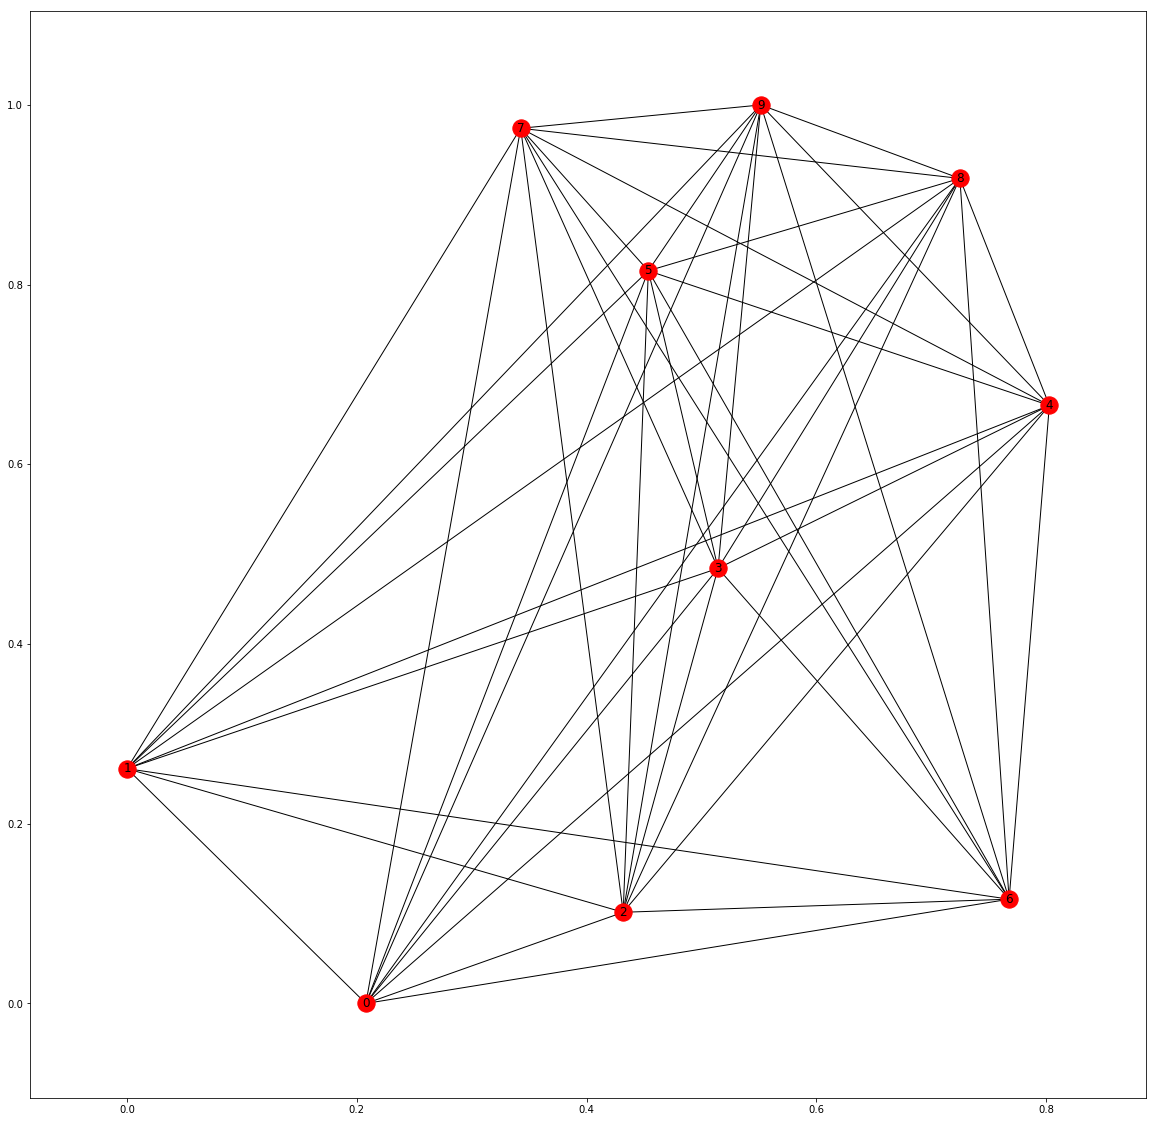

Watts strogatz (no rewire) awareness graph


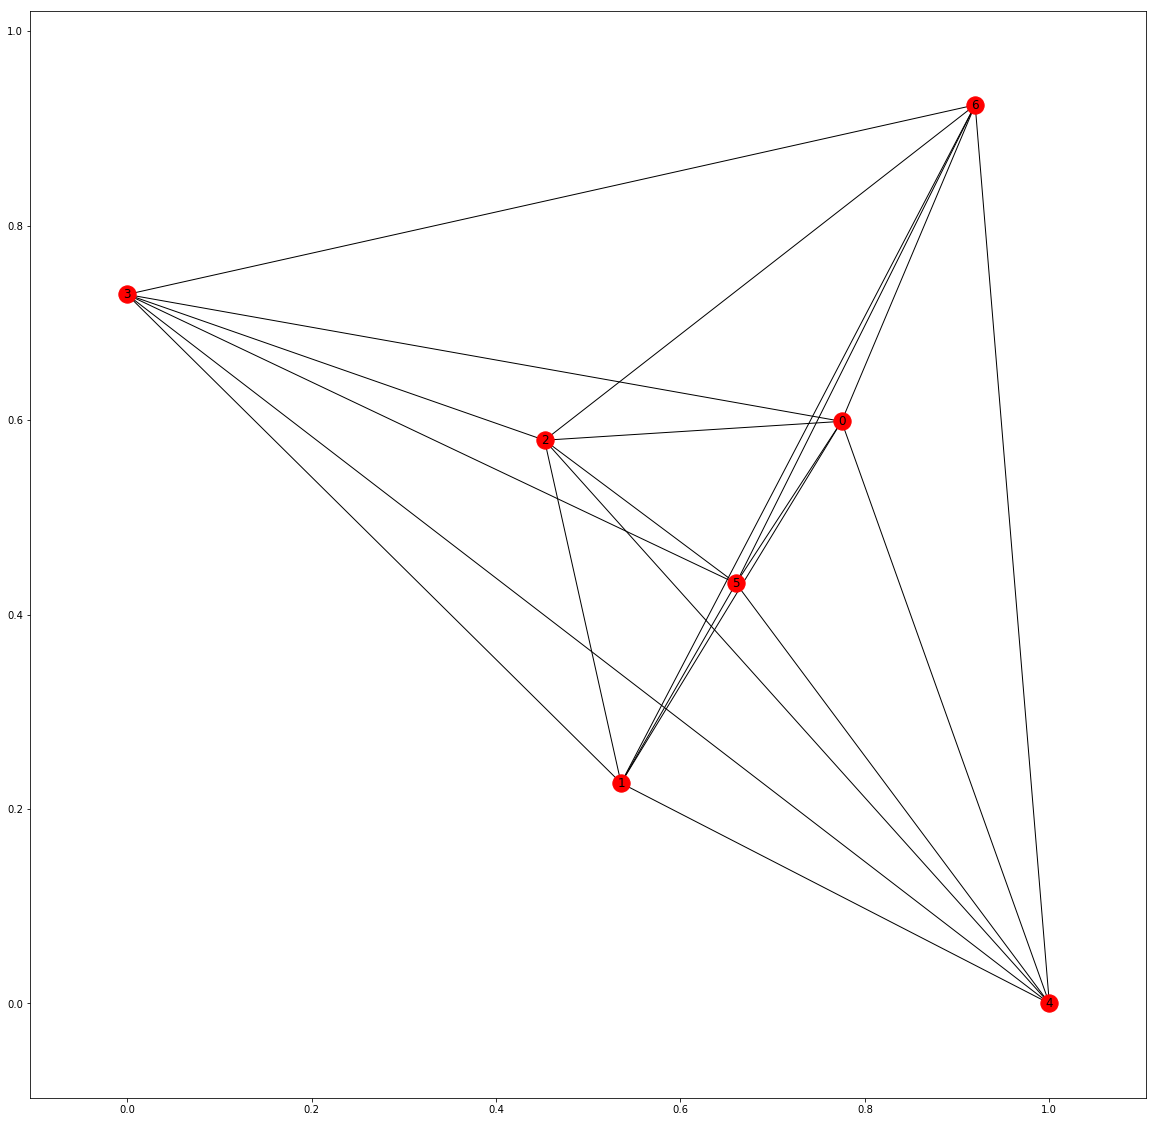

{0: array([ 0.77471378,  0.59866868]),
 1: array([ 0.53560611,  0.22664101]),
 2: array([ 0.45268242,  0.57926734]),
 3: array([ 0.        ,  0.72917167]),
 4: array([ 1.,  0.]),
 5: array([ 0.66029371,  0.43203582]),
 6: array([ 0.91954921,  0.92407901])}

In [8]:
#sanity test of coverage max algorithm
PLTREE1_AWARENESS = construct_awareness_from_contact_graph(PLTREE1)
print "Power law tree awareness graph"
draw_graph_helper(PLTREE1_AWARENESS)

print "Watts strogatz (no rewire) awareness graph"
WS1_AWARENESS = construct_awareness_from_contact_graph(WS1)
draw_graph_helper(WS1_AWARENESS)


One node soln (set([5]), 4.833333333333333)
Two node soln, greedy (set([2, 5]), 7.75)
Two node soln, opt (set([2, 5]), 7.75)


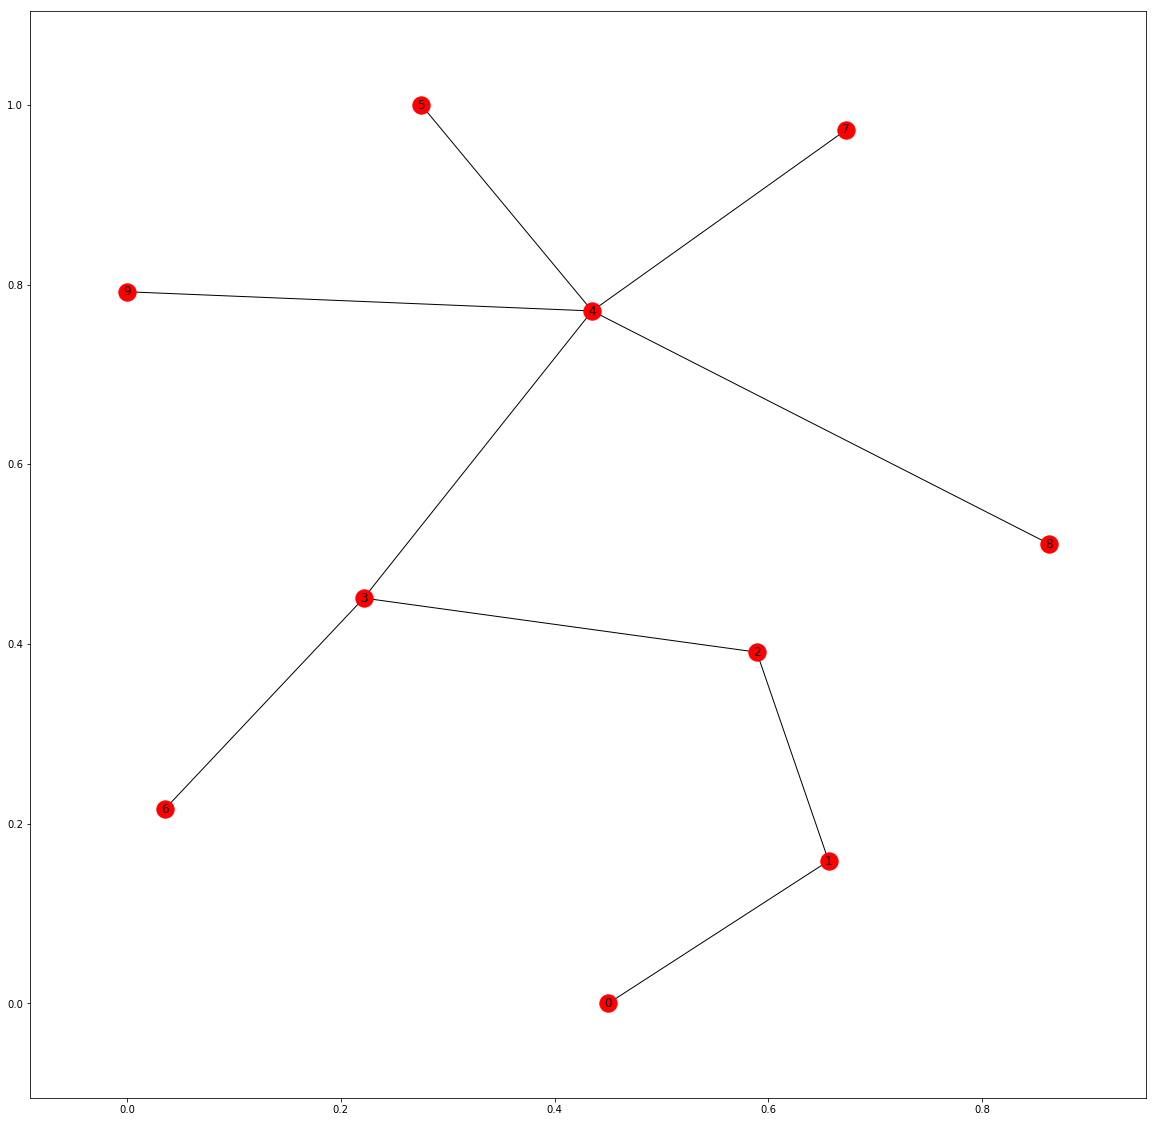

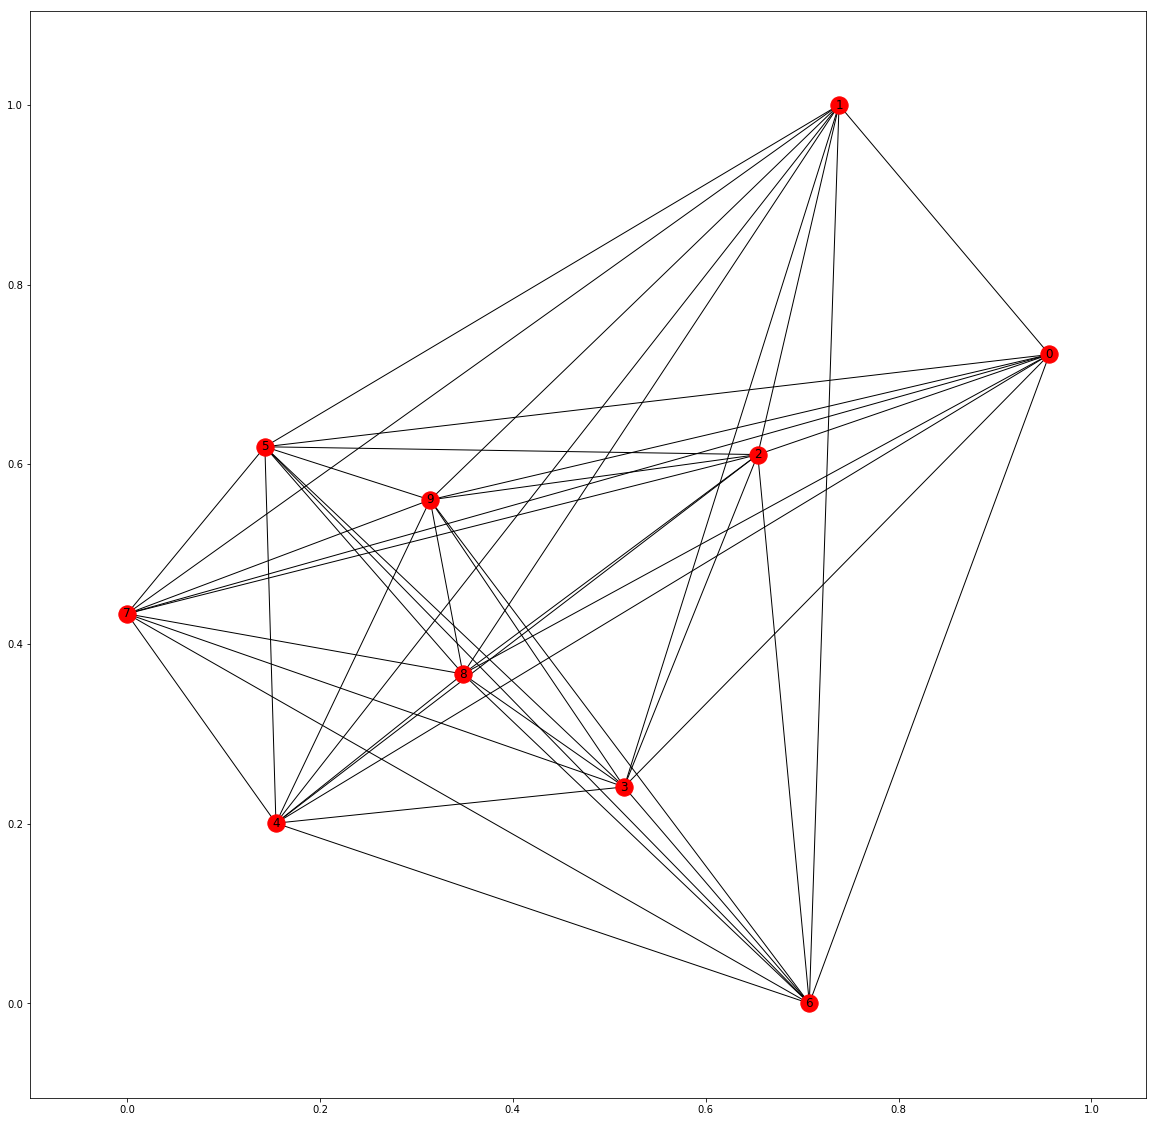

{0: array([ 0.95632021,  0.72227495]),
 1: array([ 0.73824717,  1.        ]),
 2: array([ 0.6539816 ,  0.61088213]),
 3: array([ 0.51546096,  0.24099419]),
 4: array([ 0.15439067,  0.20062985]),
 5: array([ 0.14291145,  0.61956281]),
 6: array([ 0.70743787,  0.        ]),
 7: array([ 0.        ,  0.43366573]),
 8: array([ 0.34830961,  0.36666138]),
 9: array([ 0.31425658,  0.56043998])}

In [9]:
S1 = greedy_expected_max_coverage_set(PLTREE1_AWARENESS,1,1)
print "One node soln",S1

S2 = greedy_expected_max_coverage_set(PLTREE1_AWARENESS,2,1)
print "Two node soln, greedy",S2

S3 = greedy_expected_max_coverage_set(PLTREE1_AWARENESS,2,1)
print "Two node soln, opt", S3

draw_graph_helper(PLTREE1,"spring")

draw_graph_helper(PLTREE1_AWARENESS,"spring")




Two node soln to watts strogatz contact greedy (set([0, 2]), 7)
Two node soln to watts strogatz contact opt (set([0, 2]), 7)
Two node soln to WS awareness greedy (set([0, 4]), 6.620068027210885)
Two node soln to WS awareness opt (set([0, 4]), 6.620068027210885)


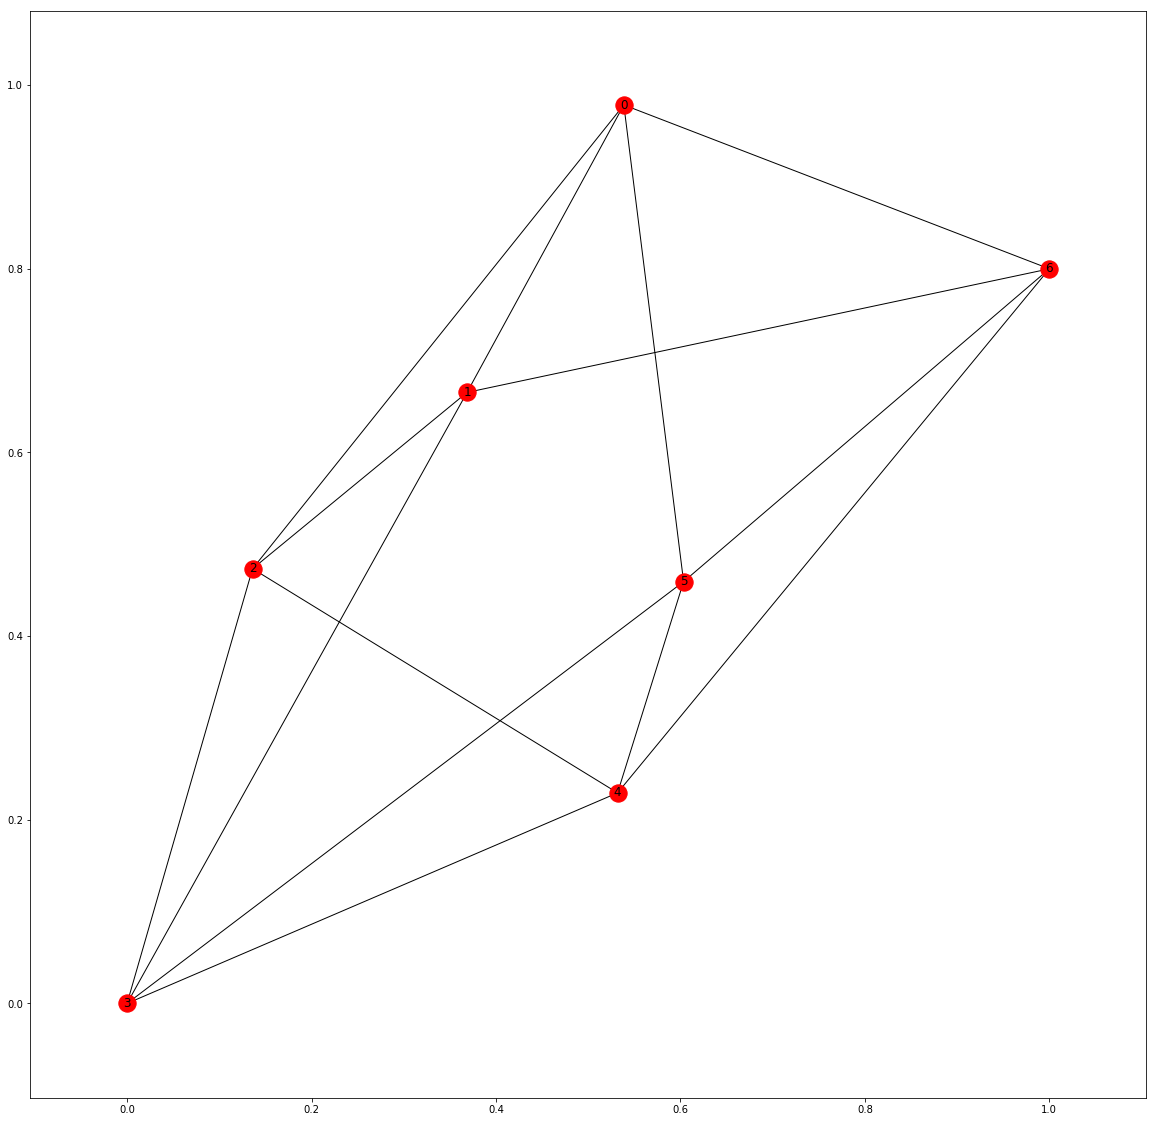

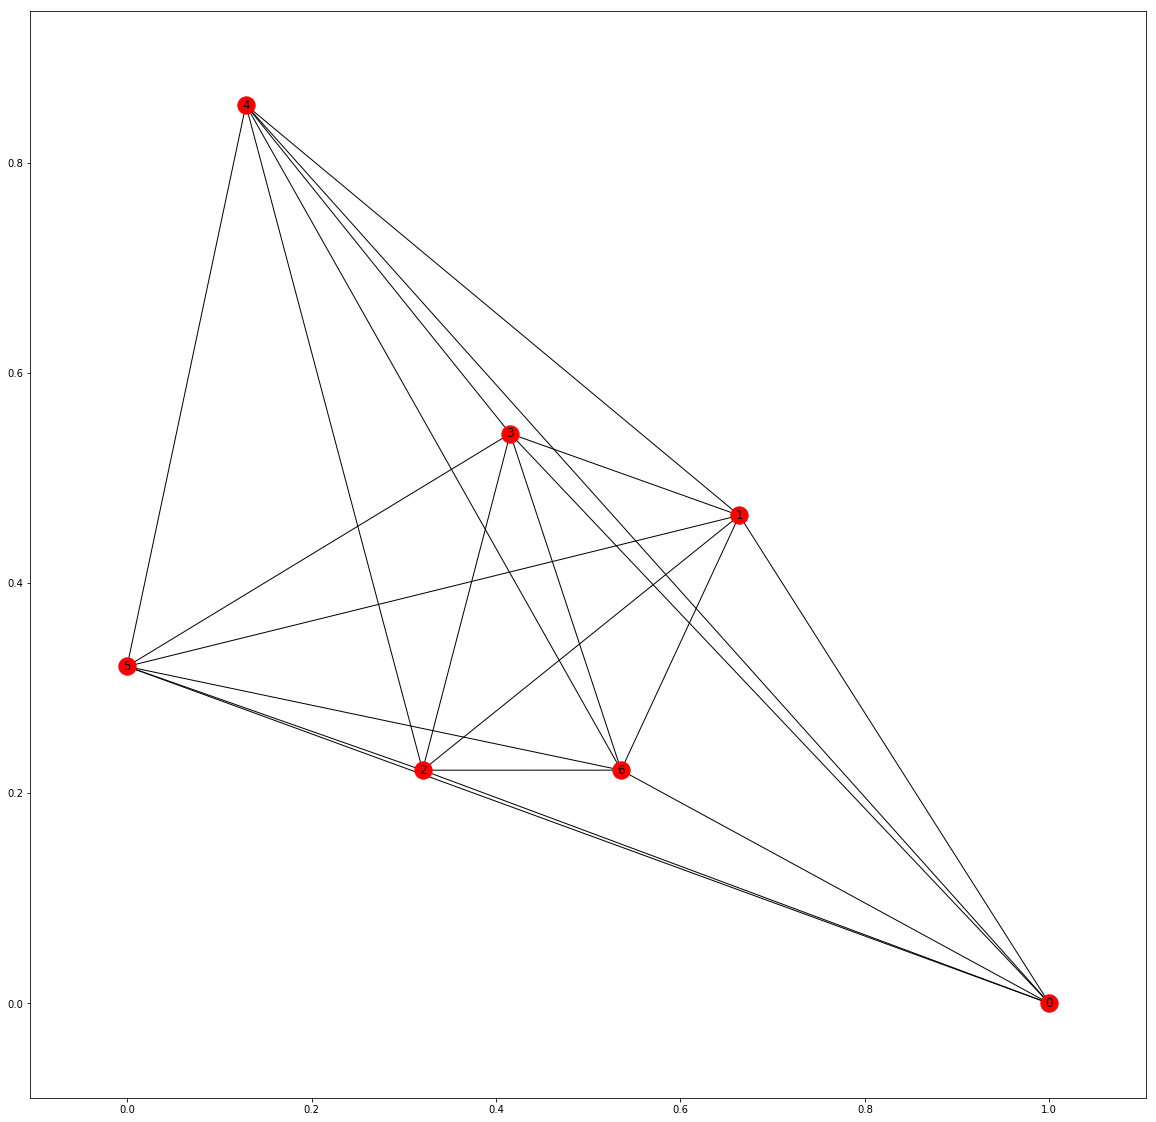

{0: array([ 1.,  0.]),
 1: array([ 0.66388199,  0.46447752]),
 2: array([ 0.32044161,  0.22199609]),
 3: array([ 0.41541674,  0.54229865]),
 4: array([ 0.12886118,  0.85513638]),
 5: array([ 0.        ,  0.32073881]),
 6: array([ 0.53571466,  0.22203955])}

In [10]:
S0 = greedy_expected_max_coverage_set(WS1,2,1)
print "Two node soln to watts strogatz contact greedy",S0

S1 = greedy_expected_max_coverage_set(WS1,2,2)
print "Two node soln to watts strogatz contact opt",S1

S2 = greedy_expected_max_coverage_set(WS1_AWARENESS,2,1)
print "Two node soln to WS awareness greedy",S2

S3 = greedy_expected_max_coverage_set(WS1_AWARENESS,2,2)
print "Two node soln to WS awareness opt",S3

draw_graph_helper(WS1,"spring")

draw_graph_helper(WS1_AWARENESS,"spring")



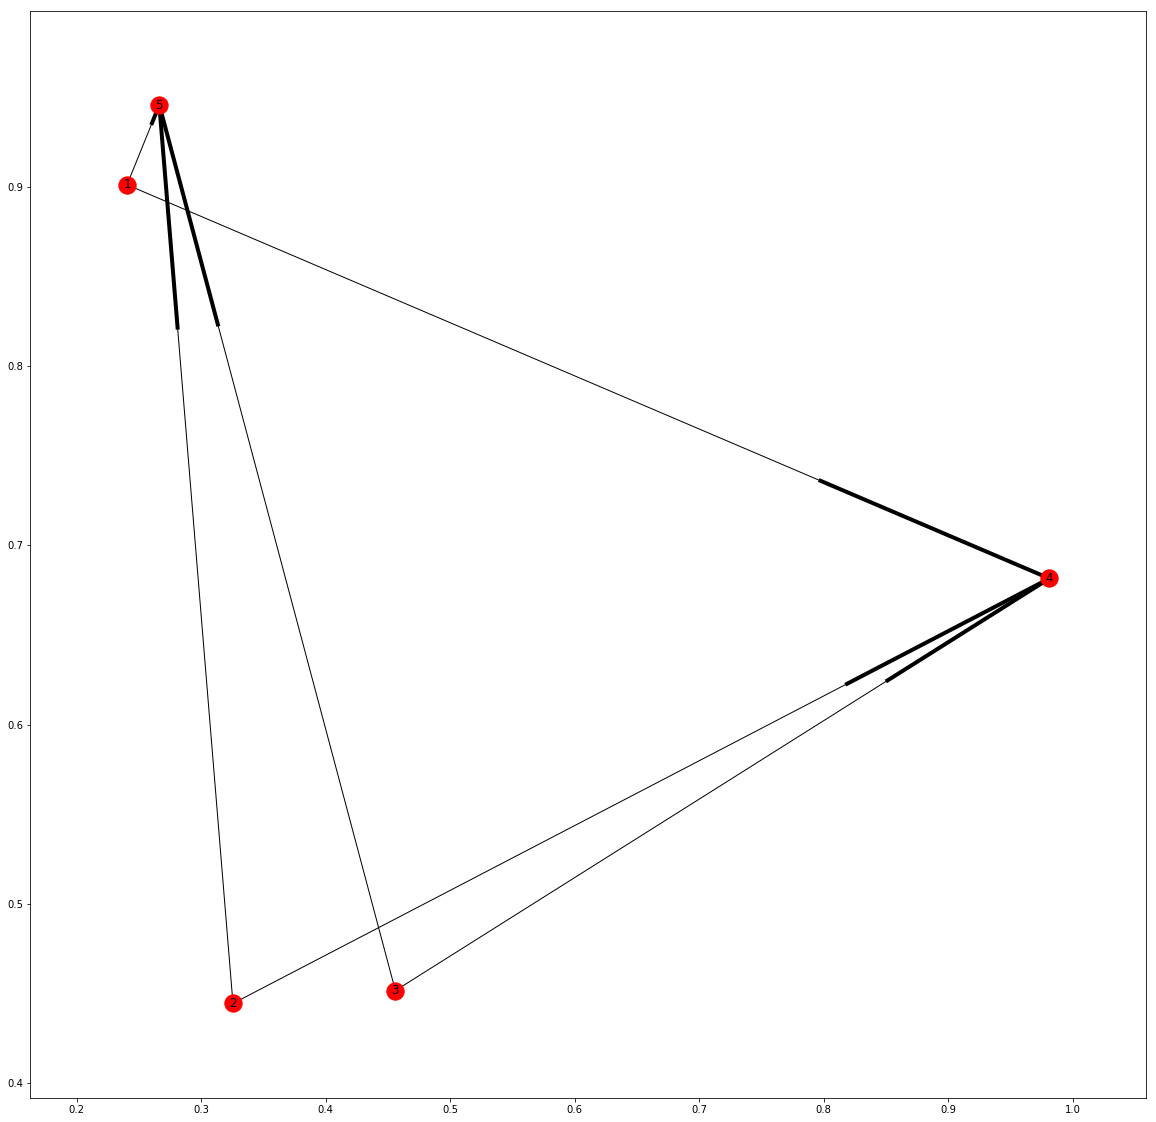

Expected coverage toy example, opt
(set([1, 2]), 3.6398200000000003)
**

Expected coverage toy example, greedy (will choose non-opt due to non-robustness to small differences)
(set([1, 3]), 3.42994)


In [11]:
#another sanity test

G = nx.DiGraph()
G.add_edge(1,4,weight=.1)
G.add_edge(1,5,weight=.7999)
G.add_edge(2,4,weight=.7999)
G.add_edge(2,5,weight=.1)
G.add_edge(3,4,weight=.5)
G.add_edge(3,5,weight=.4)

draw_graph_helper(G,"random")

print "Expected coverage toy example, opt"
print greedy_expected_max_coverage_set(G,2,2)

print "**\n\nExpected coverage toy example, greedy (will choose non-opt due to non-robustness to small differences)"
print greedy_expected_max_coverage_set(G,2,1)


In [12]:
"""
#Given a contact graph G and a committee, form the clique subgraph of the committee and perform probabilistic triadic closure
#on all unclosed triads which include two committee members
def simple_committee_closure_augmentation(G,committee,closure_threshold):
    H = G.copy()
    
    for x,y in comb(committee,2):
        #add committee-committee edge
        H.add_edge(x,y,weight=1)
        
        #Close triads
        for n in set(G[x].keys()).union(G[y].keys()):
            
            if (n not in G[y]): #then unclosed triad, missing edge n-y
                r = rand.random()
                if (r<closure_threshold):
                    H.add_edge(n,y,weight=1)
            elif (y not in G[x]): #unclosed triad missing edge n-x
                r = rand.random()
                if (r<closure_threshold):
                    H.add_edge(n,x,weight=1)
                    
    return H
"""

def committee_closure_augmentation(G,committee,closure_threshold):
    H = G.copy()
    
    for x,y in comb(committee,2):
        #add committee-committee edge
        H.add_edge(x,y,weight=1.0)
        
        #Close triads which have two committee members
        for n in set(G[x].keys()).union(G[y].keys()).difference(set([x,y])):
            
            if (n not in G[y]): #then unclosed triad, missing edge n-y
                r = rand.random()
                if (r<closure_threshold):
                    H.add_edge(n,y,weight=1)
            elif (y not in G[x]): #unclosed triad missing edge n-x
                r = rand.random()
                if (r<closure_threshold):
                    H.add_edge(n,x,weight=1)
    
    #Close triads which have one committee member
    for x in committee:
        for y in set(G[x].keys()).difference(set(committee)):
            for z in set(G[y].keys()).difference(set(committee)):
                if (z not in G[x].keys()): #if unclosed triad
                    r = rand.random()
                    if (r<closure_threshold):
                        H.add_edge(n,x,weight=1.0)
    return H
    

In [13]:
#Plot distribution of times at which given network is covered at alpha fraction by k nodes
def get_distribution_coverage_time(G_init,k,alpha,closure_param,trials=100,max_tries=100,alg="greedy",draw_freq=0,show_ecc=False):
    time_dist = []
    num_nodes = len(G_init.nodes())
    
    graphs = []
    
    for t in range(trials):
        G = G_init.copy()
        graphs.append([])
        pos = None
        tries = 0
        if (alg.startswith("greedy")):
            #Greedy coverage algorithm
            committee,covg = greedy_expected_max_coverage_set(construct_awareness_from_contact_graph(G),k,1)
            print "T=0"
            if (draw_freq != 0):
                pos = draw_graph_helper(G,"spring",pos)
            graphs[-1].append(G)
            
                            #if showing eccentricities
            if (show_ecc):
                ecc_dict = nx.eccentricity(G)
                plt.hist(ecc_dict.values(),bins=range(max(ecc_dict.values())+2))
                plt.title("Iteration 0 of Greedy Committee Formation:\n Contact Network Eccentricity Distribution")
                plt.show()
            
            while (covg < alpha*num_nodes and tries < max_tries):
                G = committee_closure_augmentation(G,committee,closure_param)
                graphs[-1].append(G)
            
                print "T=%i" % (tries+1)
                
                #draw according to frequency
                if (draw_freq != 0 and (tries+1) % draw_freq == 0):
                    pos = draw_graph_helper(G,"spring",pos)
                
                #if showing eccentricities
                if (show_ecc):
                    ecc_dict = nx.eccentricity(G)
                    plt.hist(ecc_dict.values(),bins=range(max(ecc_dict.values())+2))
                    plt.title("Iteration %i of Greedy Committee Formation:\n Contact Network Eccentricity Distribution" % (tries+1))
                    plt.show()
                
                tries += 1
             
                committee,covg = greedy_expected_max_coverage_set(construct_awareness_from_contact_graph(G),k,1)
                    
                print "Chose commmittee", committee, "with coverage ", covg
        elif (alg.startswith("random")):
            #Greedy coverage algorithm
            
            committee = np.random.choice(G.nodes(),k)
            
            #ensure uniqueness
            while (len(committee) != len(set(committee))):
                 committee = np.random.choice(G.nodes(),k)
                    
            #covg = get_exp_coverage(G,G.nodes(),np.random.choice(G.nodes(),k))
            
            #Calculate coverage of greedily selected committee
            _,covg = greedy_expected_max_coverage_set(construct_awareness_from_contact_graph(G),k,1)
            
            if (draw_freq != 0):
                print "T=",0
                pos = draw_graph_helper(G,"spring",pos)
                
            graphs[-1].append(G)
            
            #if showing eccentricities
            if (show_ecc):
                ecc_dict = nx.eccentricity(G)
                plt.hist(ecc_dict.values(),bins=range(max(ecc_dict.values())+2))
                plt.title("Iteration 0 of Random Committee Formation:\n Contact Network Eccentricity Distribution" )
                plt.show()
                    
            while (covg < alpha*num_nodes and tries < max_tries):
            
                #Get coverage quality under greedy method
                _,covg = greedy_expected_max_coverage_set(construct_awareness_from_contact_graph(G),k,1)
            
                #augment with random committee
                G = committee_closure_augmentation(G,committee,closure_param)
                
                
                #draw according to frequency
                if (draw_freq != 0 and (tries+1) % draw_freq == 0):
                    print "T=",tries+1
                    pos = draw_graph_helper(G,"spring",pos)
                
                #if showing eccentricities
                if (show_ecc):
                    ecc_dict = nx.eccentricity(G)
                    plt.hist(ecc_dict.values(),bins=range(max(ecc_dict.values())+2))
                    plt.title("Iteration %i of Random Committee Formation:\n Contact Network Eccentricity Distribution" % (tries+1))
                    plt.show()
                
                graphs[-1].append(G)
                
                #draw_graph_helper(G,"spring")
                tries += 1
                
                #randomly choose committee
                committee = np.random.choice(G.nodes(),k)
                
                #ensure uniqueness
                while (len(committee) != len(set(committee))):
                     committee = np.random.choice(G.nodes(),k)



        
        if (covg < alpha*(len(G.nodes()))):
            print "ERROR: Coverage was %f, not high enough after Max tries= %i exceeded" % (covg,max_tries)
        print "Finished at time ", tries, " with committee", committee, " with coverage ", covg
        time_dist.append(tries)
        
    return time_dist,graphs
    

In [ ]:
#Toy examples


COMMITTEE_SZ = 3

COVERAGE_MIN = 0.75
CLOSURE_PARAM = 0.20
trials = 10

G_list = []

#List of graphs to try
"""
N = 10
WS_K = 2
WS_P = 0.0
COMMITTEE_SZ = 3
G_list.append([get_watts_strogatz_graph(N,WS_K,WS_P),"Watts Strogatz N=%i,Deg=%i,Rewire Prob=%.2f" % (N,WS_K,WS_P),COMMITTEE_SZ])

N = 100
WS_K = 6
WS_P = 0.0
COMMITTEE_SZ = 6
G_list.append([get_watts_strogatz_graph(N,WS_K,WS_P),"Watts Strogatz N=%i,Deg=%i,Rewire Prob=%.2f" % (N,WS_K,WS_P),COMMITTEE_SZ])

N = 10
WS_K = 4
WS_P = 0.10
COMMITTEE_SZ = 3
G_list.append([get_watts_strogatz_graph(N,WS_K,WS_P),"Watts Strogatz N=%i,Deg=%i,Rewire Prob=%.2f" % (N,WS_K,WS_P),COMMITTEE_SZ])


N = 100
WS_K = 6
WS_P = 0.10
COMMITTEE_SZ = 6
G_list.append([get_watts_strogatz_graph(N,WS_K,WS_P),"Watts Strogatz N=%i,Deg=%i,Rewire Prob=%.2f" % (N,WS_K,WS_P),COMMITTEE_SZ])

N = 10
WS_K = 4
WS_P = 0.75
COMMITTEE_SZ = 3
G_list.append([get_watts_strogatz_graph(N,WS_K,WS_P),"Watts Strogatz N=%i,Deg=%i,Rewire Prob=%.2f" % (N,WS_K,WS_P),COMMITTEE_SZ])

N = 100
WS_K = 6
WS_P = 0.75
"""
N = 50
ER_P = .05
for c in range(3):
    G_list.append([get_undirected_ER_graph(N,ER_P),"ER #%i : N=%i,Prob=%.2f" % (c,N,ER_P),COMMITTEE_SZ])


N = 50
ER_P = .2
for c in range(3):
    G_list.append([get_undirected_ER_graph(N,ER_P),"ER #%i: N=%i,Prob=%.2f" % (c,N,ER_P),COMMITTEE_SZ])


#draw_graph_helper(G,"random")
#draw_graph_helper(G,"spring")
print "Coverage minimum fraction %.2f, committee size %i and closure prob %.2f" % (COVERAGE_MIN,COMMITTEE_SZ,CLOSURE_PARAM)
for G,name,committee_sz in G_list:
        
    data_greedy,_ = get_distribution_coverage_time(G,COMMITTEE_SZ,COVERAGE_MIN,CLOSURE_PARAM,trials,max_tries=N/COMMITTEE_SZ,alg="greedy",draw_freq=1)
    data_rand,_ = get_distribution_coverage_time(G,COMMITTEE_SZ,COVERAGE_MIN,CLOSURE_PARAM,trials,max_tries=N/COMMITTEE_SZ,alg="random",draw_freq=1)


    # Two subplots, the axes array is 1-d
    plt.figure(figsize=(15,15))
    f, axarr = plt.subplots(2, sharex=True)
   
    binwidth=1
    #print data
    hist_greedy,bins_greedy = np.histogram(data_greedy,bins=range(min(data_greedy), max(data_greedy) + binwidth+1, binwidth))                                 
    width_greedy = 0.5 * (bins_greedy[1] - bins_greedy[0])
    center_greedy = (bins_greedy[:-1] + bins_greedy[1:]) / 2
    
    axarr[0].bar(center_greedy, hist_greedy, align='center', width=width_greedy)
    axarr[0].set_title("Distribution of Number of Greedily Selected %i-Committee Formations to reach %.2f coverage over %i trials \n Graph is %s" %(committee_sz,COVERAGE_MIN,trials,name))
    
    
    hist_rand,bins_rand = np.histogram(data_rand,bins=range(min(data_rand), max(data_rand) + binwidth+1, binwidth))                                 
    width_rand = 0.5 * (bins_rand[1] - bins_rand[0])
    center_rand = (bins_rand[:-1] + bins_rand[1:]) / 2
    
    axarr[1].bar(center_rand, hist_rand, align='center', width=width_rand)
    axarr[1].set_title("Distribution of Number of Randomly Selected %i-Committee Formations to reach %.2f coverage over %i trials \n Graph is %s" %(committee_sz,COVERAGE_MIN,trials,name))
    
    plt.show()
    
print "DONE"

In [ ]:
#Toy examples


COMMITTEE_SZ = 4
NUM_COPIES=5
COVERAGE_MIN = 0.75
CLOSURE_PARAM = 0.20
trials = 1

G_list = []

#List of graphs to try

N = 50
ER_P = .05

for c in range(NUM_COPIES):
    G_list.append([get_undirected_ER_graph(N,ER_P),"ER #%i: N=%i,Prob=%.2f" % (c,N,ER_P),COMMITTEE_SZ])


#draw_graph_helper(G,"random")
#draw_graph_helper(G,"spring")
print "Coverage minimum fraction %.2f, committee size %i and closure prob %.2f" % (COVERAGE_MIN,COMMITTEE_SZ,CLOSURE_PARAM)
for G,name,committee_sz in G_list:
        
    data_greedy,_ = get_distribution_coverage_time(G,COMMITTEE_SZ,COVERAGE_MIN,CLOSURE_PARAM,trials,max_tries=N/COMMITTEE_SZ,alg="greedy")
    data_rand,_ = get_distribution_coverage_time(G,COMMITTEE_SZ,COVERAGE_MIN,CLOSURE_PARAM,trials,max_tries=N/COMMITTEE_SZ,alg="random")


    # Two subplots, the axes array is 1-d
    f, axarr = plt.subplots(2, sharey=True)
   
    binwidth=1
    #print data
    hist_greedy,bins_greedy = np.histogram(data_greedy,bins=range(min(data_greedy), max(data_greedy) + binwidth+1, binwidth))                                 
    width_greedy = 0.5 * (bins_greedy[1] - bins_greedy[0])
    center_greedy = (bins_greedy[:-1] + bins_greedy[1:]) / 2
    
    axarr[0].bar(center_greedy, hist_greedy, align='center', width=width_greedy)
    axarr[0].set_title("Distribution of Number of Greedily Selected %i-Committee Formations to reach %.2f coverage over %i trials \n Graph is %s" %(committee_sz,COVERAGE_MIN,trials,name))
    
    
    hist_rand,bins_rand = np.histogram(data_rand,bins=range(min(data_rand), max(data_rand) + binwidth+1, binwidth))                                 
    width_rand = 0.5 * (bins_rand[1] - bins_rand[0])
    center_rand = (bins_rand[:-1] + bins_rand[1:]) / 2
    
    axarr[1].bar(center_rand, hist_rand, align='center', width=width_rand)
    axarr[1].set_title("Distribution of Number of Randomly Selected %i-Committee Formations to reach %.2f coverage over %i trials \n Graph is %s" %(committee_sz,COVERAGE_MIN,trials,name))
    
    plt.show()
    
print "DONE"

In [33]:
CONTACT_COL = 4 #indexed from 0
AWARENESS_COL = 6 #indexed from 0

contact_graphs = []
awareness_graphs = []
data_files = []


from os import listdir as ld

#Load data files from data directory
for filename in ld("./data/"):
    if (filename.endswith(".txt")):
        data_files.append(open("./data/%s" % filename))

    


#construct graphs
for data_file in data_files:
    contact_graph = nx.Graph()
    awareness_graph = nx.Graph()
    
    #read lines
    for i,line in enumerate(data_file):
        if (len(line.split()) != 10):
            print line, "line",i," not long enough", data_file
            continue
        if ((line.split())[CONTACT_COL] == '1'):
            #print "int", (line.split())[CONTACT_COL] 
            contact_graph.add_edge(int((line.split())[0]),int((line.split())[1]),weight=1.0)
        if ((line.split())[AWARENESS_COL] == '1'):
            awareness_graph.add_edge(int((line.split())[0]),int((line.split())[1]),weight=1.0)
    print "Adding graphs ", data_file.name, "with ", len(contact_graph.nodes())," nodes and ", len(contact_graph.edges()), " edges"
    contact_graphs.append((awareness_graph,data_file.name))
    awareness_graphs.append((awareness_graph,data_file.name))
    
    
            
            
#close files
for data_file in data_files:
    data_file.close()


line 1000  not long enough <open file './data/ColPhy-clean.txt', mode 'r' at 0x7f41b2d481e0>

line 1381  not long enough <open file './data/ColPhy-clean.txt', mode 'r' at 0x7f41b2d481e0>
Adding graphs  ./data/ColPhy-clean.txt with  105  nodes and  566  edges

line 500  not long enough <open file './data/ChiSoc-clean.txt', mode 'r' at 0x7f41af8ad540>

line 1001  not long enough <open file './data/ChiSoc-clean.txt', mode 'r' at 0x7f41af8ad540>

line 1502  not long enough <open file './data/ChiSoc-clean.txt', mode 'r' at 0x7f41af8ad540>

line 2003  not long enough <open file './data/ChiSoc-clean.txt', mode 'r' at 0x7f41af8ad540>

line 2504  not long enough <open file './data/ChiSoc-clean.txt', mode 'r' at 0x7f41af8ad540>

line 3005  not long enough <open file './data/ChiSoc-clean.txt', mode 'r' at 0x7f41af8ad540>

line 3506  not long enough <open file './data/ChiSoc-clean.txt', mode 'r' at 0x7f41af8ad540>

line 4007  not long enough <open file './data/ChiSoc-clean.txt', mode 'r' at 0x7f4

Name:  ./data/ColPhy-clean.txt


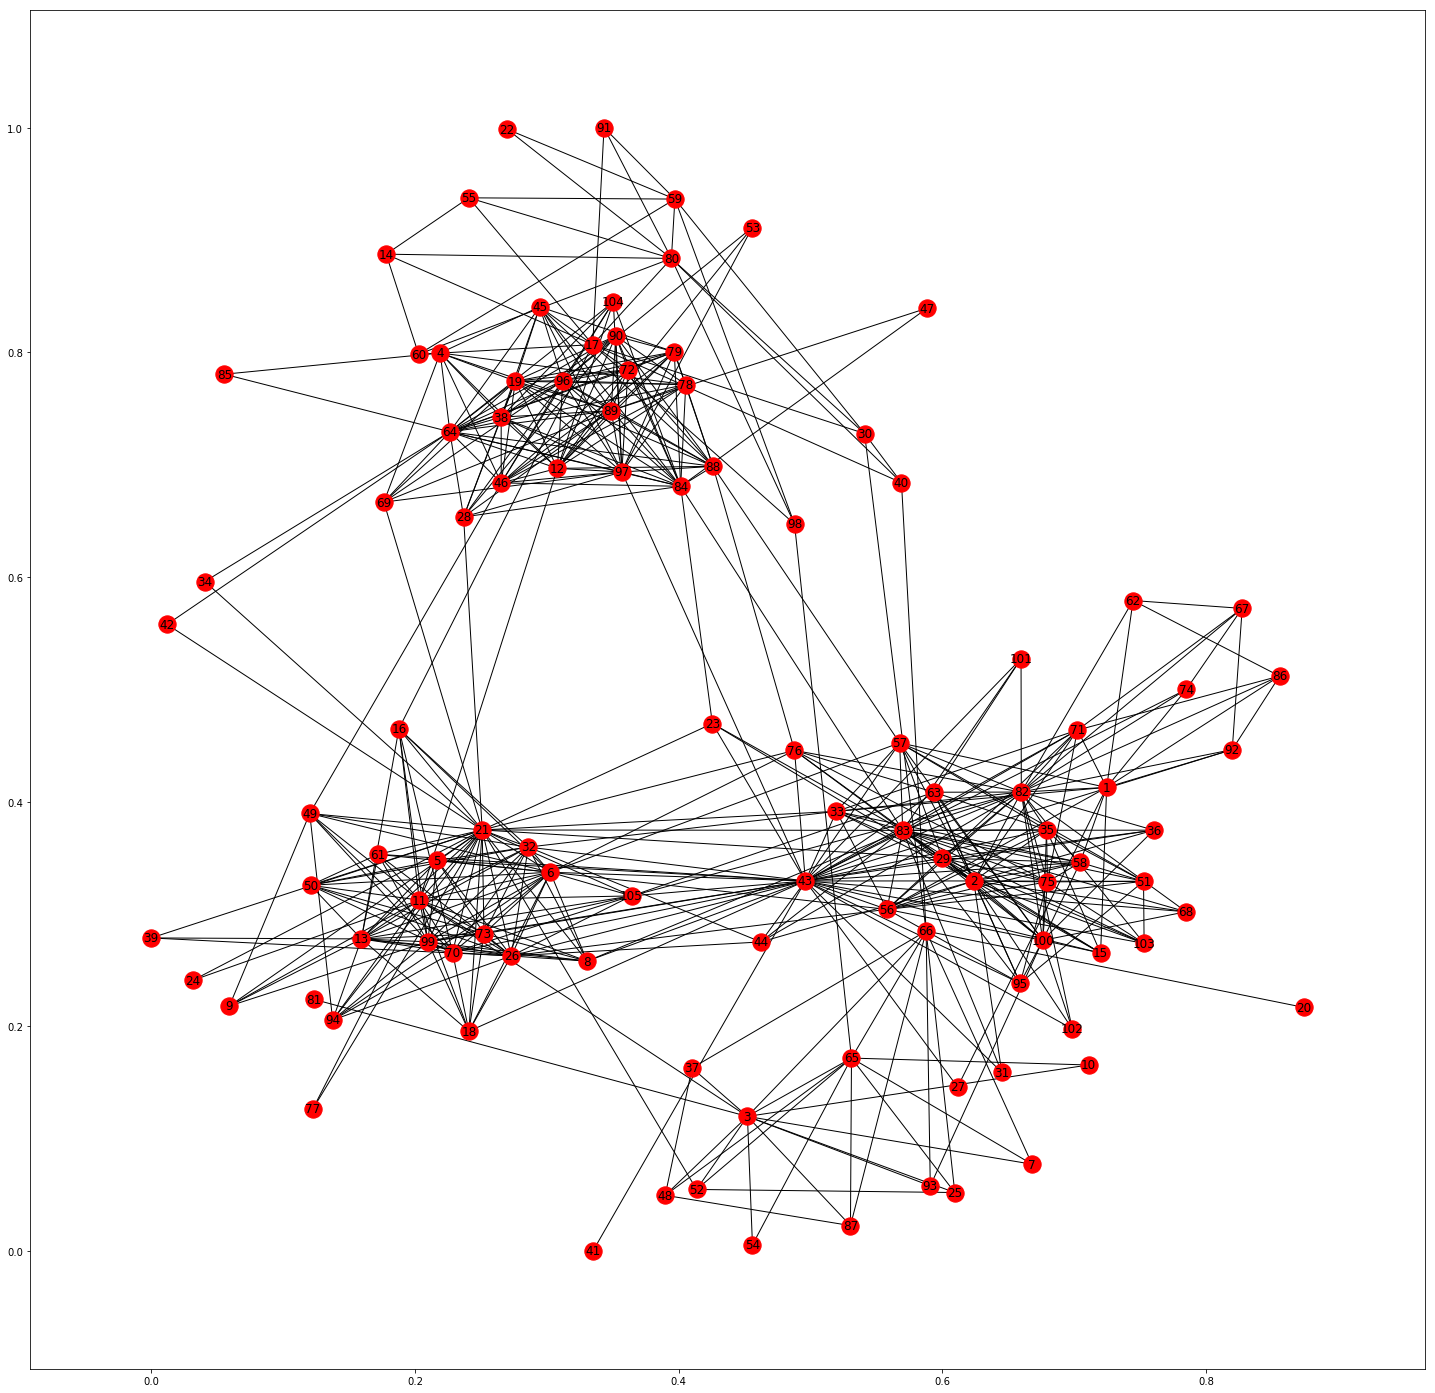

Name:  ./data/ChiSoc-clean.txt


KeyboardInterrupt: 

In [8]:
for g,name in contact_graphs:
    print "Name: ",name
    draw_graph_helper(g,"spring")

In [34]:

#standard data
single_contact_networks_list = [(g,name) for g,name in contact_graphs]

In [14]:
G_list = []

#List of graphs to try


#two graphs together
for G,H in comb(contact_graphs,2):

    
    S = nx.convert_node_labels_to_integers(G[0],first_label=0)
    R = nx.convert_node_labels_to_integers(H[0],first_label=-1*len(H[0].nodes()))
    """
    print "G here"
    draw_graph_helper(S,"spring",drawNodeLabels=True)
    print "H Here"
    draw_graph_helper(R,"spring",drawNodeLabels=True)
    """
    
    F = nx.compose(S,R)
    G_list.append((F, "%s - merged %s" % (G[1], H[1])))
    
    """
    print "Both merged as F =","%s - merged %s" % (G[1], H[1])
    draw_graph_helper(F,positionFlag="spring",drawNodeLabels=True)
    """
    
    #make sure no overlap
    for v in S.nodes():
        assert(set(S[v].keys()).intersection(set(R.nodes())) == set())
    
    for w in R.nodes():
        assert(set(R[w].keys()).intersection(set(S.nodes())) == set())

#make deepcopy of list
combined_contact_networks_list = copy.deepcopy(G_list)


In [48]:
#Find closure time on real graphs


COMMITTEE_SZ = 6
NUM_COPIES = 5
COVERAGE_MIN = 0.85
CLOSURE_PARAM = 0.075
trials = 3
repeats = 1


#G_list = combined_contact_networks_list
G_list = single_contact_networks_list



print "Starting simulation"
print "Coverage minimum fraction %.2f, committee size %i and closure prob %.2f" % (COVERAGE_MIN,COMMITTEE_SZ,CLOSURE_PARAM)
for graph_desc in G_list:
    
    print graph_desc
    G,name = graph_desc
    data_greedy = []
    data_rand = []
    
    #repeat process several times, adding all times to one list
    for c in range(repeats):
        print "Using greedy method"
        t,graphs = get_distribution_coverage_time(G,COMMITTEE_SZ,COVERAGE_MIN,CLOSURE_PARAM,trials,max_tries=int(1.5*len(G.nodes()))/COMMITTEE_SZ,alg="greedy",draw_freq=0,show_ecc=False)

        data_greedy.append((t,graphs))
        #data_greedy.append(tuple(t,graphs) for t,graphs in get_distribution_coverage_time(G,COMMITTEE_SZ,COVERAGE_MIN,CLOSURE_PARAM,trials,max_tries=N/COMMITTEE_SZ,alg="greedy",draw_freq=1))
        print "Using random method"
        t,graphs =  get_distribution_coverage_time(G,COMMITTEE_SZ,COVERAGE_MIN,CLOSURE_PARAM,trials,max_tries=int(1.5*len(G.nodes()))/COMMITTEE_SZ,alg="random",draw_freq=0,show_ecc=False)
        data_rand.append((t,graphs))

    #print "Data Greedy = " ,data_greedy
    
    #copy time distribution of convergence
    time_dist_greedy = []
    time_dist_rand = []
    
    f = plt.figure("%s : greedy" % name)
    
    for record in data_greedy:
        #Save times
        times = record[0]
        time_dist_greedy = time_dist_greedy + times
        
        #Record diameter trends
        graph_trials = record[1]
        for trial in graph_trials:
            diameter = []
            #print "Checking graphs ", trial, "for trial" ,graph_trials
            for graph in trial:
                
                print "Graph edges",len(graph.edges())
                diameter.append(nx.diameter(graph))
            line_greedy, = plt.plot(range(len(diameter)),diameter,color='b',label='Greedy')
    
            print "Diameter trend (greedy) from graph ",name, " is",diameter
    print "Times recorded for greedy are ",time_dist_greedy
    
    #plt.show()

    
    #f = plt.figure("%s : random" % name)
    
    for record in data_rand:
        #Save times
        times = record[0]
        time_dist_rand = time_dist_rand + times
        
        #Record diameter trends
        graph_trials = record[1]
        for trial in graph_trials:
            diameter = []
            for graph in trial:
                print "Graph edges",len(graph.edges())
                diameter.append(nx.diameter(graph))
            line_rand, = plt.plot(range(len(diameter)),diameter,color='r',label='Random')
            print "Diameter trend (random) from graph ",name, " is",diameter
    print "Times recorded for random are ",time_dist_rand
    
    plt.legend(handles=[line_greedy, line_rand])
    plt.show()
    
    
    #Plot convergence statistics
    # Two subplots, the axes array is 1-d
    f, axarr = plt.subplots(2, sharex=True)
   
    binwidth=1
    #print data
    hist_greedy,bins_greedy = np.histogram(time_dist_greedy,bins=range(min(time_dist_greedy), max(time_dist_greedy) + binwidth+1, binwidth))                                 
    width_greedy = 0.5 * (bins_greedy[1] - bins_greedy[0])
    center_greedy = (bins_greedy[:-1] + bins_greedy[1:]) / 2
    
    axarr[0].bar(center_greedy, hist_greedy, align='center', width=width_greedy)
    axarr[0].set_title("Distribution of Number of Greedily Selected %i-Committee Formations to reach %.2f coverage over %i trials \n Graph is %s" %(COMMITTEE_SZ,COVERAGE_MIN,trials,name))
    
    hist_rand,bins_rand = np.histogram(time_dist_rand,bins=range(min(time_dist_rand), max(time_dist_rand) + binwidth+1, binwidth))                                 
    width_rand = 0.5 * (bins_rand[1] - bins_rand[0])
    center_rand = (bins_rand[:-1] + bins_rand[1:]) / 2
    
    axarr[1].bar(center_rand, hist_rand, align='center', width=width_rand)
    axarr[1].set_title("Distribution of Number of Randomly Selected %i-Committee Formations to reach %.2f coverage over %i trials \n Graph is %s" %(COMMITTEE_SZ,COVERAGE_MIN,trials,name))
    
    #plt.show()
    break
print "DONE"

[(<networkx.classes.graph.Graph object at 0x7f4f14170450>, './data/ColSoc-clean.txt')]
Starting simulation
Coverage minimum fraction 0.85, committee size 6 and closure prob 0.07
(<networkx.classes.graph.Graph object at 0x7f4f14170450>, './data/ColSoc-clean.txt')
Using greedy method
T=0
T=1
Chose commmittee set([97, 131, 6, 105, 28, 61]) with coverage  124.322155666
T=2
Chose commmittee set([97, 131, 6, 105, 28, 61]) with coverage  127.586724087
T=3
Chose commmittee set([97, 131, 6, 105, 28, 61]) with coverage  128.319831342
T=4
Chose commmittee set([97, 131, 88, 28, 61, 31]) with coverage  131.730928731
T=5
Chose commmittee set([131, 6, 88, 28, 61, 31]) with coverage  134.678129592
Finished at time  5  with committee set([131, 6, 88, 28, 61, 31])  with coverage  134.678129592
T=0
T=1
Chose commmittee set([97, 131, 6, 105, 28, 61]) with coverage  123.971405819
T=2
Chose commmittee set([97, 131, 6, 105, 28, 61]) with coverage  126.611792615
T=3
Chose commmittee set([97, 131, 87, 105, 28,

KeyboardInterrupt: 

In [14]:
G_list[0][0]



[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105]

In [28]:
def list_local_bridges(G):
    local_bridges = []
    for v in G.nodes():
        nbrs = G[v].keys()
        twoHopNbrs = []
        for w in nbrs:
            twoHopNbrs = twoHopNbrs + G[w].keys()
        
        for n in nbrs:
            if (n not in twoHopNbrs):
                local_bridges.append((v,n))
    return local_bridges
                

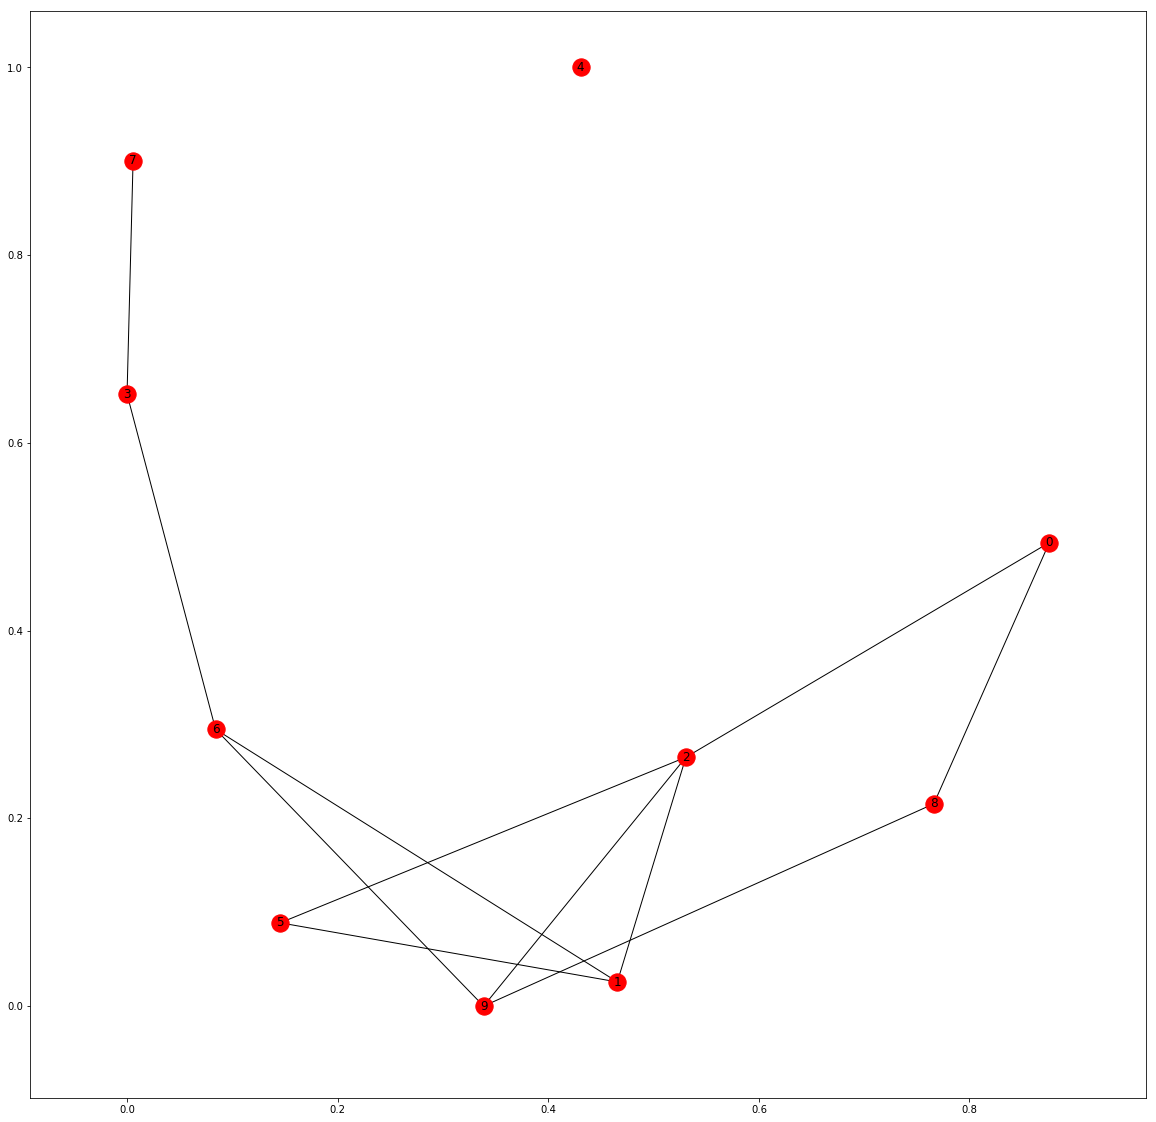

{0: array([ 0.87584623,  0.49391436]),
 1: array([ 0.46558908,  0.02572476]),
 2: array([ 0.53068161,  0.26515014]),
 3: array([ 0.        ,  0.65198939]),
 4: array([ 0.43069357,  1.        ]),
 5: array([ 0.1454648 ,  0.08873031]),
 6: array([ 0.08408597,  0.29488871]),
 7: array([ 0.0057324 ,  0.90090654]),
 8: array([ 0.76613436,  0.21554971]),
 9: array([ 0.33861786,  0.        ])}

In [29]:
G = get_undirected_ER_graph(10,.2)
draw_graph_helper(G,"spring")


In [30]:
print list_local_bridges(G)

[(0, 8), (0, 2), (1, 6), (2, 0), (2, 9), (3, 6), (3, 7), (6, 1), (6, 3), (6, 9), (7, 3), (8, 0), (8, 9), (9, 8), (9, 2), (9, 6)]


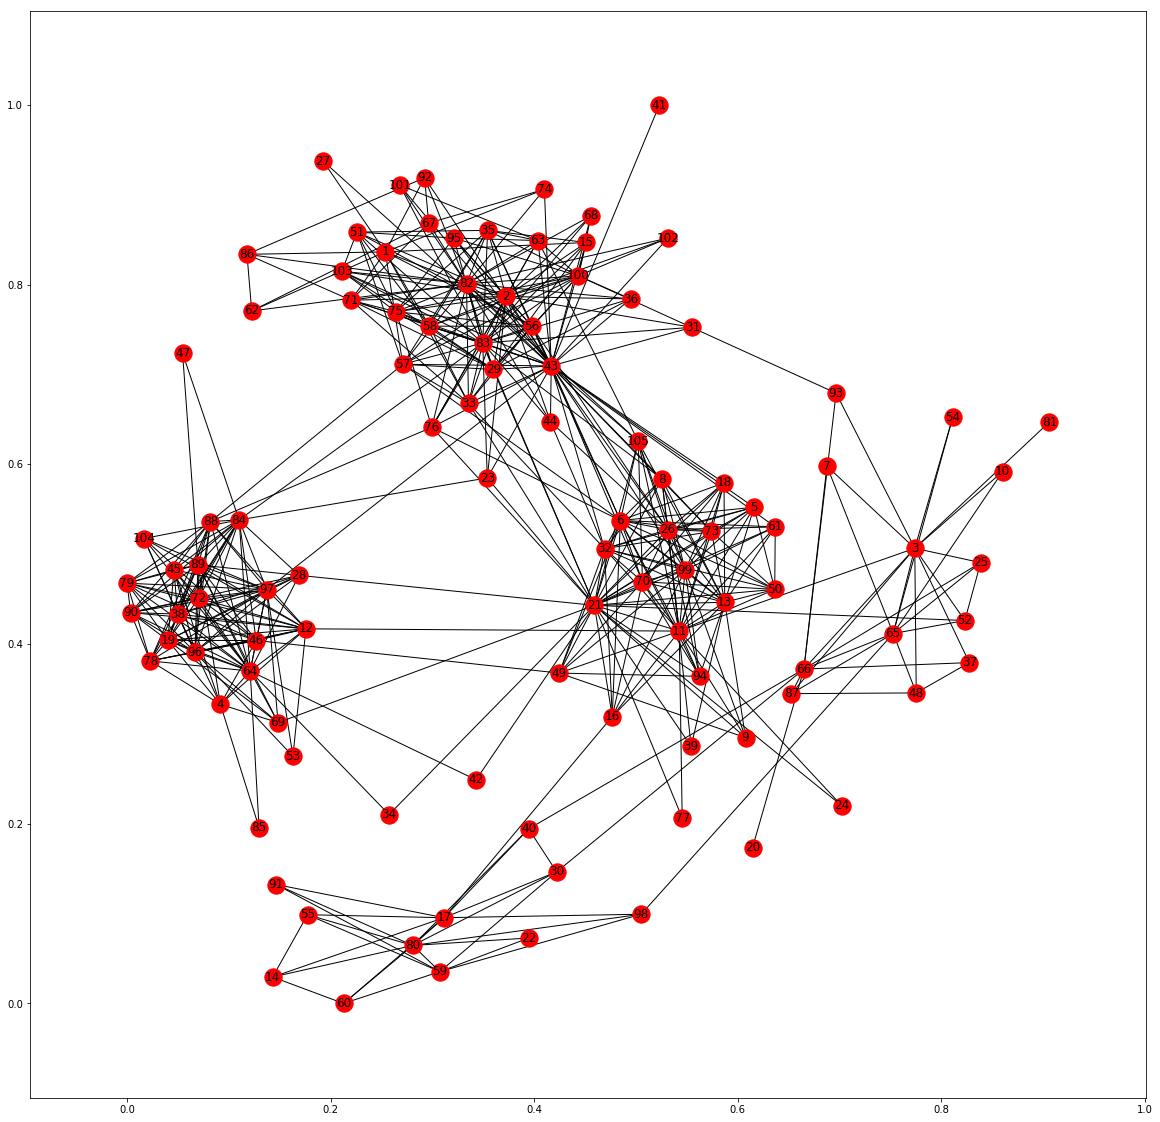

[(1, 33), (1, 71), (1, 74), (1, 15), (1, 82), (1, 86), (1, 56), (1, 57), (1, 58), (1, 27), (1, 92), (1, 62), (2, 15), (2, 23), (2, 29), (2, 31), (2, 33), (2, 35), (2, 36), (2, 43), (2, 44), (2, 51), (2, 56), (2, 57), (2, 58), (2, 63), (2, 68), (2, 71), (2, 75), (2, 76), (2, 82), (2, 83), (2, 95), (2, 100), (2, 102), (2, 103), (3, 65), (3, 66), (3, 37), (3, 7), (3, 10), (3, 11), (3, 48), (3, 81), (3, 52), (3, 54), (3, 87), (3, 25), (3, 93), (4, 64), (4, 69), (4, 38), (4, 12), (4, 45), (4, 46), (4, 19), (4, 85), (4, 89), (4, 78), (5, 32), (5, 11), (5, 6), (5, 73), (5, 43), (5, 13), (5, 50), (5, 99), (5, 21), (5, 26), (6, 32), (6, 18), (6, 99), (6, 70), (6, 8), (6, 73), (6, 11), (6, 76), (6, 13), (6, 16), (6, 49), (6, 50), (6, 21), (6, 43), (6, 105), (6, 56), (6, 57), (6, 26), (6, 61), (6, 94), (7, 65), (7, 66), (8, 32), (8, 11), (8, 73), (8, 43), (8, 13), (8, 99), (8, 83), (8, 21), (8, 26), (9, 99), (9, 49), (9, 11), (9, 21), (9, 13), (10, 65), (11, 12), (11, 13), (11, 16), (11, 18), (11

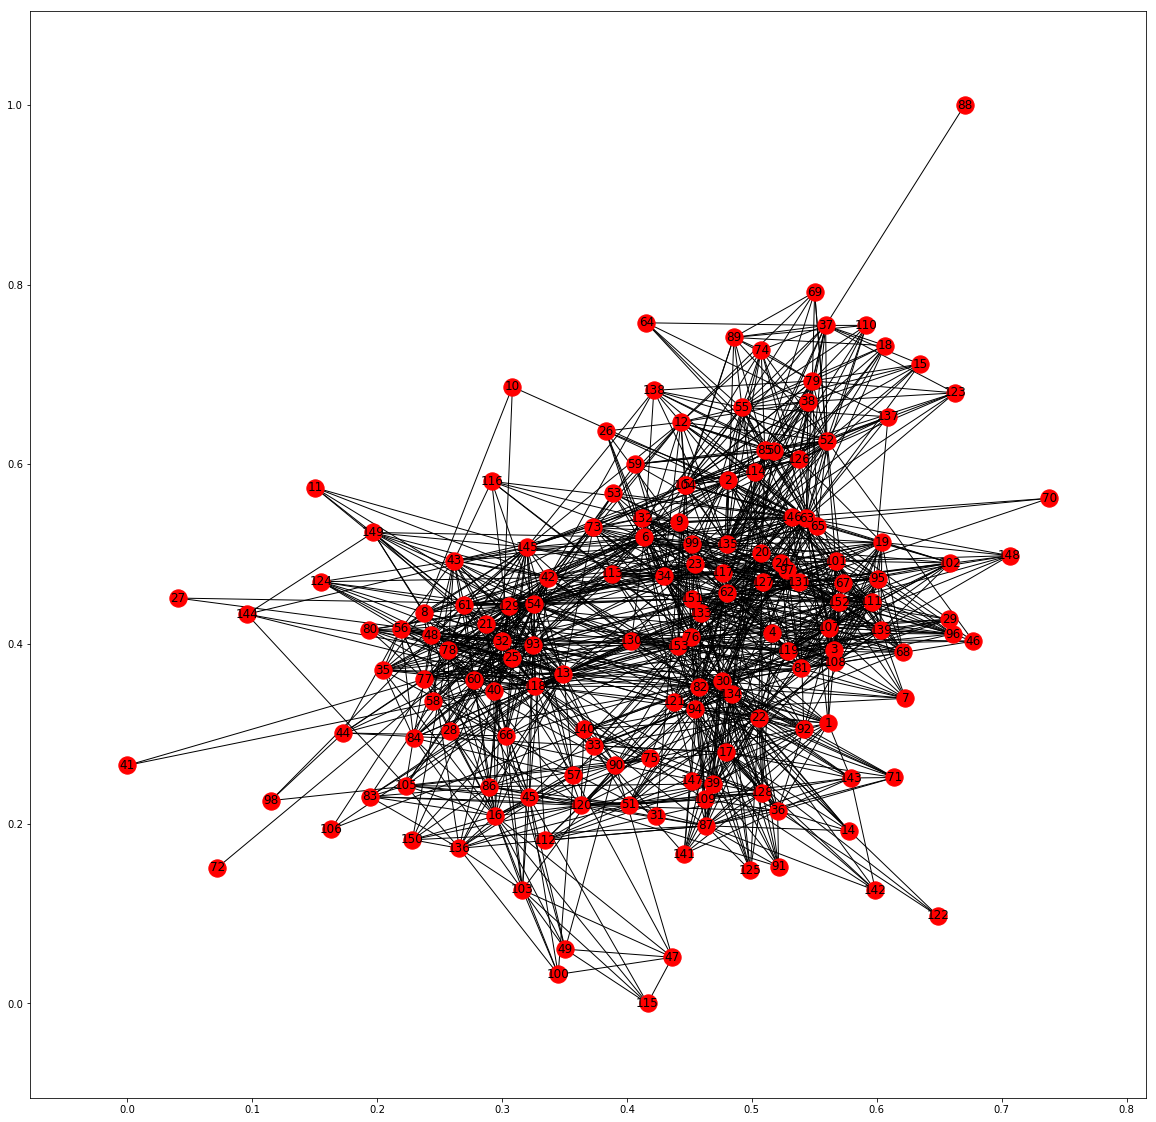

[(1, 128), (1, 34), (1, 36), (1, 134), (1, 39), (1, 107), (1, 76), (1, 143), (1, 17), (1, 82), (1, 94), (1, 22), (1, 87), (1, 152), (1, 153), (1, 90), (1, 30), (1, 63), (2, 129), (2, 3), (2, 132), (2, 5), (2, 6), (2, 9), (2, 12), (2, 145), (2, 20), (2, 23), (2, 152), (2, 26), (2, 34), (2, 38), (2, 42), (2, 52), (2, 55), (2, 59), (2, 62), (2, 63), (2, 65), (2, 74), (2, 85), (2, 95), (2, 97), (2, 99), (2, 101), (2, 104), (2, 114), (2, 117), (2, 126), (3, 51), (3, 67), (3, 101), (3, 39), (3, 95), (3, 107), (3, 111), (3, 82), (3, 19), (3, 62), (3, 119), (3, 152), (3, 153), (3, 63), (3, 30), (3, 133), (4, 128), (4, 129), (4, 132), (4, 101), (4, 96), (4, 23), (4, 76), (4, 111), (4, 81), (4, 20), (4, 118), (4, 151), (4, 152), (4, 68), (4, 119), (4, 29), (4, 127), (5, 6), (5, 135), (5, 12), (5, 145), (5, 19), (5, 153), (5, 31), (5, 34), (5, 37), (5, 38), (5, 50), (5, 52), (5, 55), (5, 56), (5, 62), (5, 63), (5, 73), (5, 76), (5, 79), (5, 85), (5, 89), (5, 126), (6, 129), (6, 131), (6, 132), (6

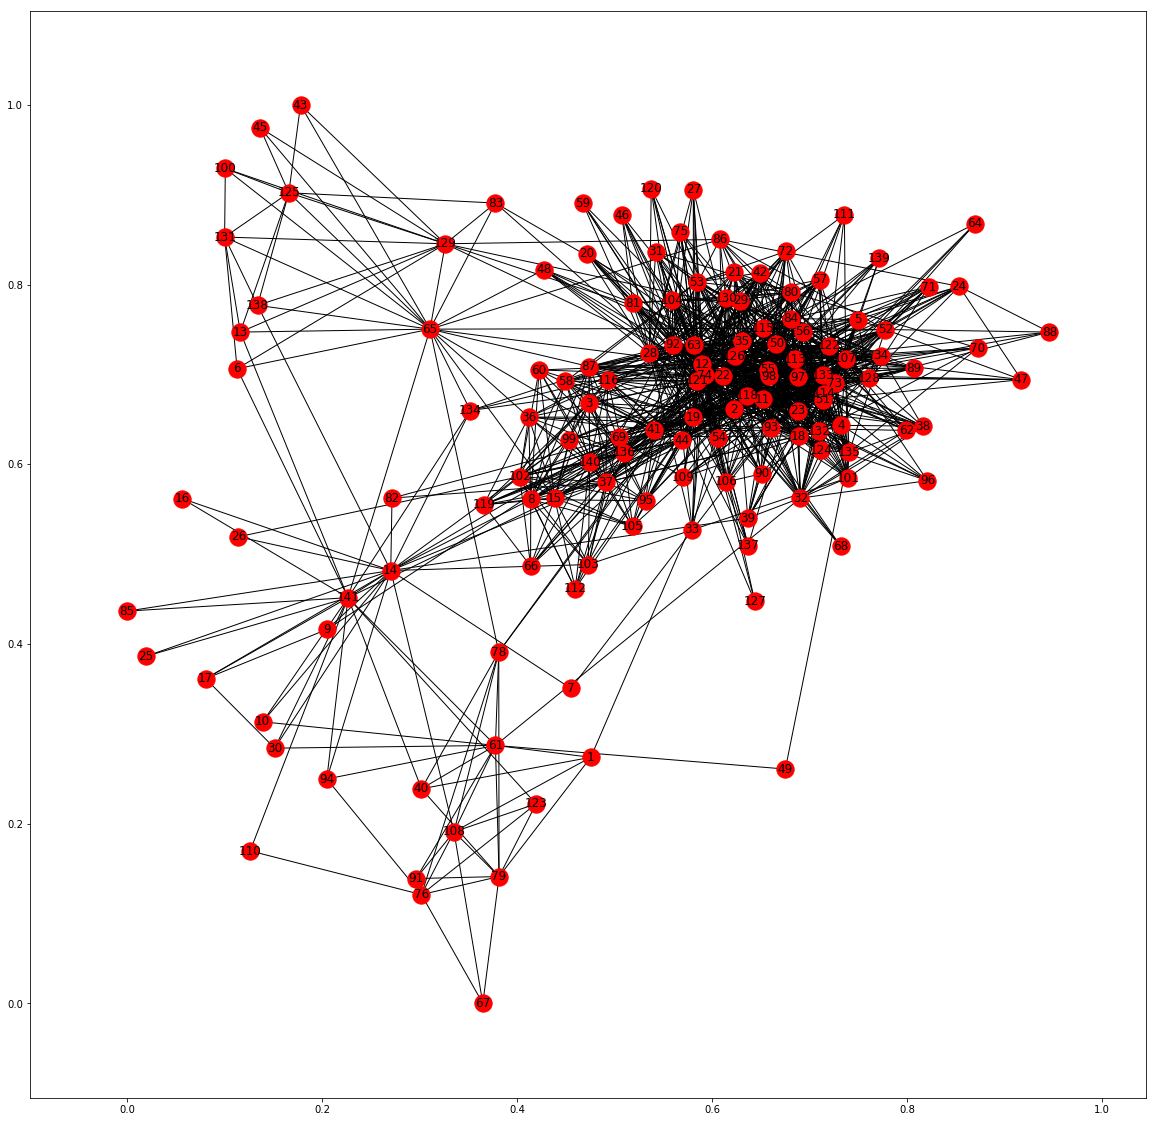

[(1, 40), (1, 108), (1, 61), (1, 118), (1, 79), (2, 130), (2, 3), (2, 5), (2, 135), (2, 136), (2, 12), (2, 15), (2, 18), (2, 19), (2, 22), (2, 28), (2, 133), (2, 37), (2, 41), (2, 44), (2, 55), (2, 56), (2, 57), (2, 63), (2, 73), (2, 74), (2, 84), (2, 89), (2, 92), (2, 97), (2, 98), (2, 104), (2, 107), (2, 113), (2, 114), (2, 115), (2, 116), (2, 121), (2, 122), (2, 126), (3, 99), (3, 102), (3, 136), (3, 105), (3, 119), (3, 140), (3, 15), (3, 111), (3, 8), (3, 19), (3, 116), (3, 41), (3, 22), (3, 87), (3, 58), (3, 95), (3, 44), (3, 63), (4, 133), (4, 135), (4, 11), (4, 18), (4, 19), (4, 22), (4, 23), (4, 32), (4, 34), (4, 35), (4, 37), (4, 38), (4, 51), (4, 55), (4, 63), (4, 73), (4, 93), (4, 107), (4, 113), (4, 114), (4, 115), (4, 121), (4, 126), (5, 128), (5, 11), (5, 132), (5, 69), (5, 73), (5, 107), (5, 44), (5, 98), (5, 24), (5, 115), (5, 113), (5, 114), (5, 51), (5, 84), (5, 118), (5, 56), (5, 52), (5, 126), (6, 65), (6, 131), (6, 141), (6, 129), (7, 93), (7, 14), (8, 136), (8, 14

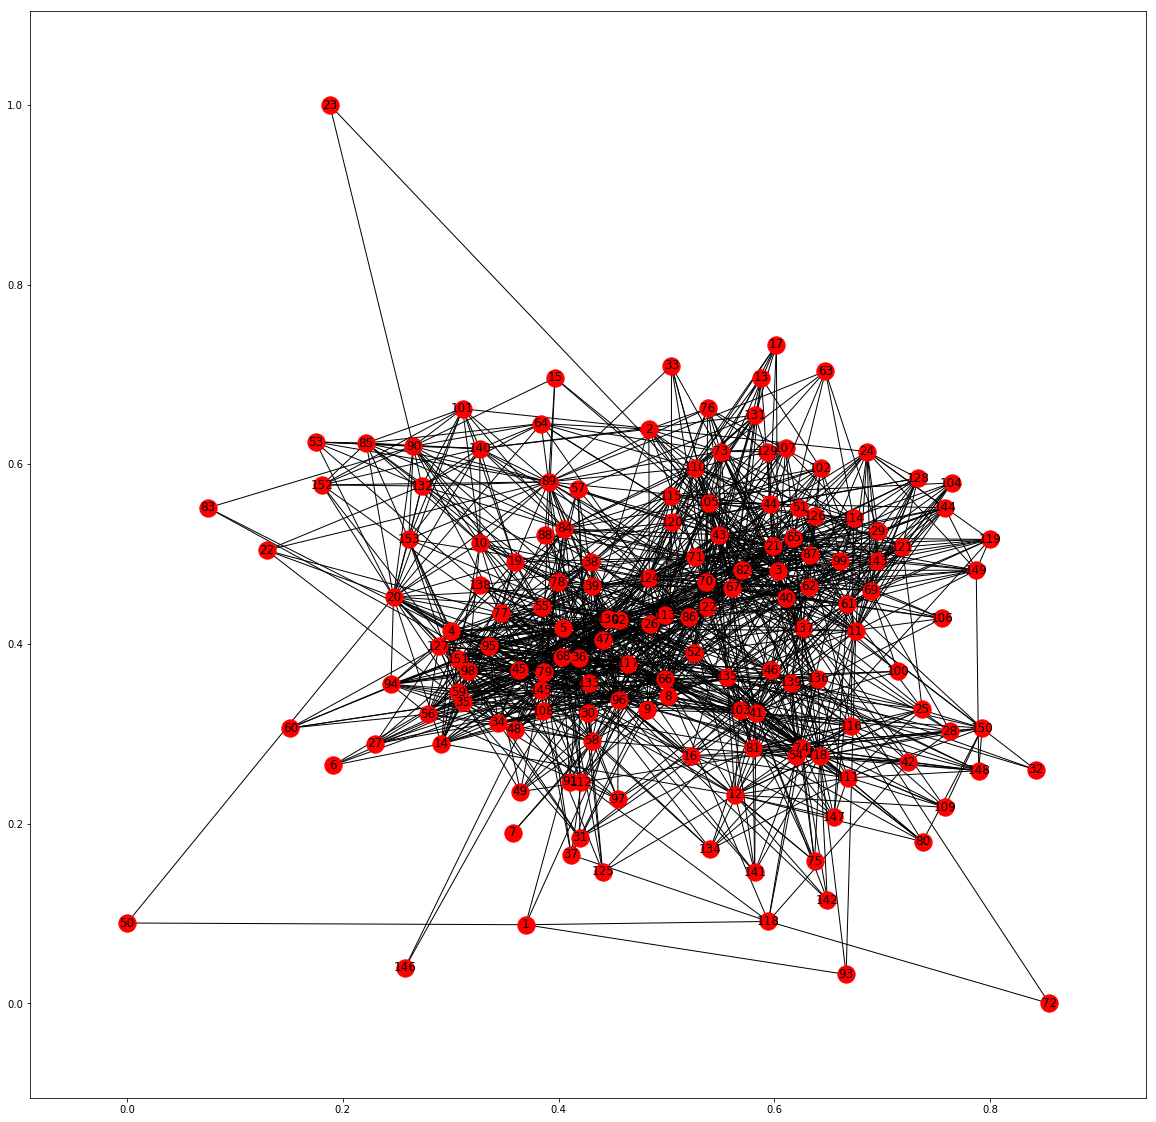

[(1, 113), (1, 50), (1, 93), (1, 118), (1, 47), (2, 64), (2, 3), (2, 36), (2, 70), (2, 73), (2, 43), (2, 76), (2, 110), (2, 140), (2, 99), (2, 105), (2, 124), (3, 128), (3, 129), (3, 5), (3, 135), (3, 8), (3, 9), (3, 11), (3, 130), (3, 15), (3, 144), (3, 17), (3, 18), (3, 21), (3, 150), (3, 24), (3, 26), (3, 32), (3, 39), (3, 41), (3, 43), (3, 44), (3, 136), (3, 54), (3, 137), (3, 61), (3, 63), (3, 64), (3, 67), (3, 70), (3, 73), (3, 76), (3, 82), (3, 84), (3, 87), (3, 88), (3, 143), (3, 92), (3, 99), (3, 100), (3, 102), (3, 105), (3, 107), (3, 109), (3, 110), (3, 111), (3, 113), (3, 114), (3, 115), (3, 119), (3, 121), (3, 124), (3, 126), (3, 149), (4, 130), (4, 5), (4, 135), (4, 138), (4, 14), (4, 145), (4, 20), (4, 151), (4, 153), (4, 27), (4, 45), (4, 55), (4, 59), (4, 66), (4, 68), (4, 77), (4, 79), (4, 83), (4, 84), (4, 92), (4, 94), (4, 95), (4, 96), (4, 112), (4, 117), (4, 122), (4, 127), (5, 138), (5, 11), (5, 14), (5, 145), (5, 20), (5, 151), (5, 35), (5, 41), (5, 55), (5, 59)

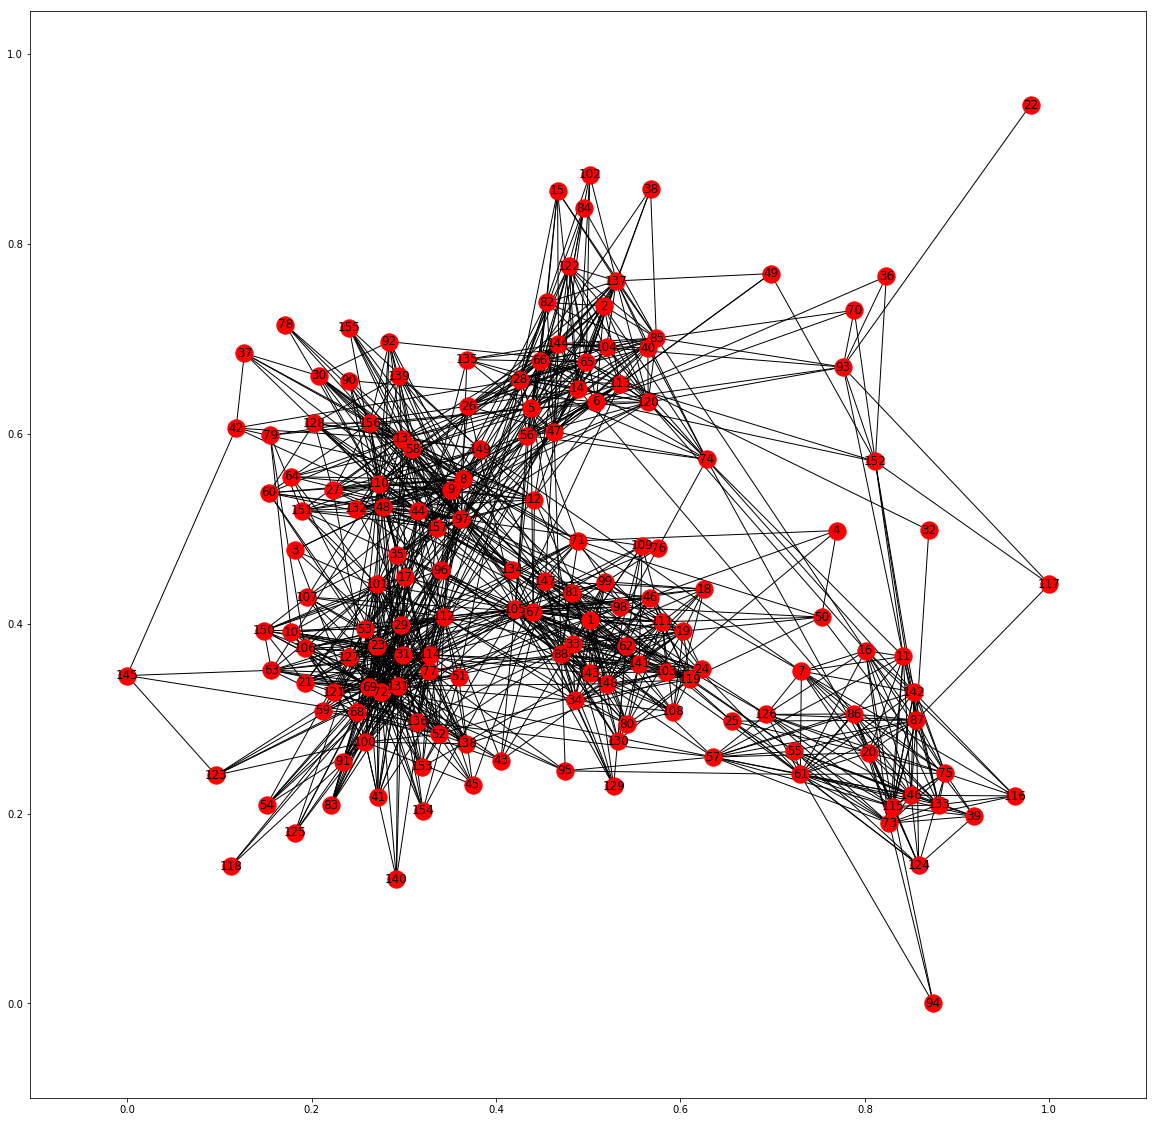

[(1, 129), (1, 130), (1, 134), (1, 12), (1, 141), (1, 143), (1, 147), (1, 148), (1, 27), (1, 33), (1, 34), (1, 62), (1, 80), (1, 81), (1, 88), (1, 99), (1, 105), (1, 108), (1, 109), (1, 111), (1, 19), (1, 119), (2, 97), (2, 66), (2, 5), (2, 6), (2, 65), (2, 137), (2, 74), (2, 14), (2, 47), (2, 144), (2, 113), (2, 82), (2, 85), (2, 120), (2, 122), (2, 28), (3, 48), (3, 112), (3, 68), (3, 77), (3, 6), (4, 98), (4, 103), (4, 50), (4, 71), (5, 33), (5, 66), (5, 67), (5, 28), (5, 9), (5, 65), (5, 97), (5, 105), (5, 13), (5, 14), (5, 47), (5, 144), (5, 82), (5, 84), (5, 85), (5, 137), (5, 120), (5, 122), (5, 156), (5, 31), (6, 48), (6, 152), (6, 36), (6, 101), (6, 70), (6, 47), (6, 144), (6, 113), (6, 90), (6, 120), (6, 122), (6, 79), (6, 93), (7, 75), (7, 133), (7, 8), (7, 11), (7, 142), (7, 16), (7, 115), (7, 116), (7, 149), (7, 86), (7, 20), (7, 61), (7, 126), (8, 132), (8, 136), (8, 9), (8, 139), (8, 12), (8, 13), (8, 144), (8, 147), (8, 21), (8, 151), (8, 25), (8, 27), (8, 156), (8, 157

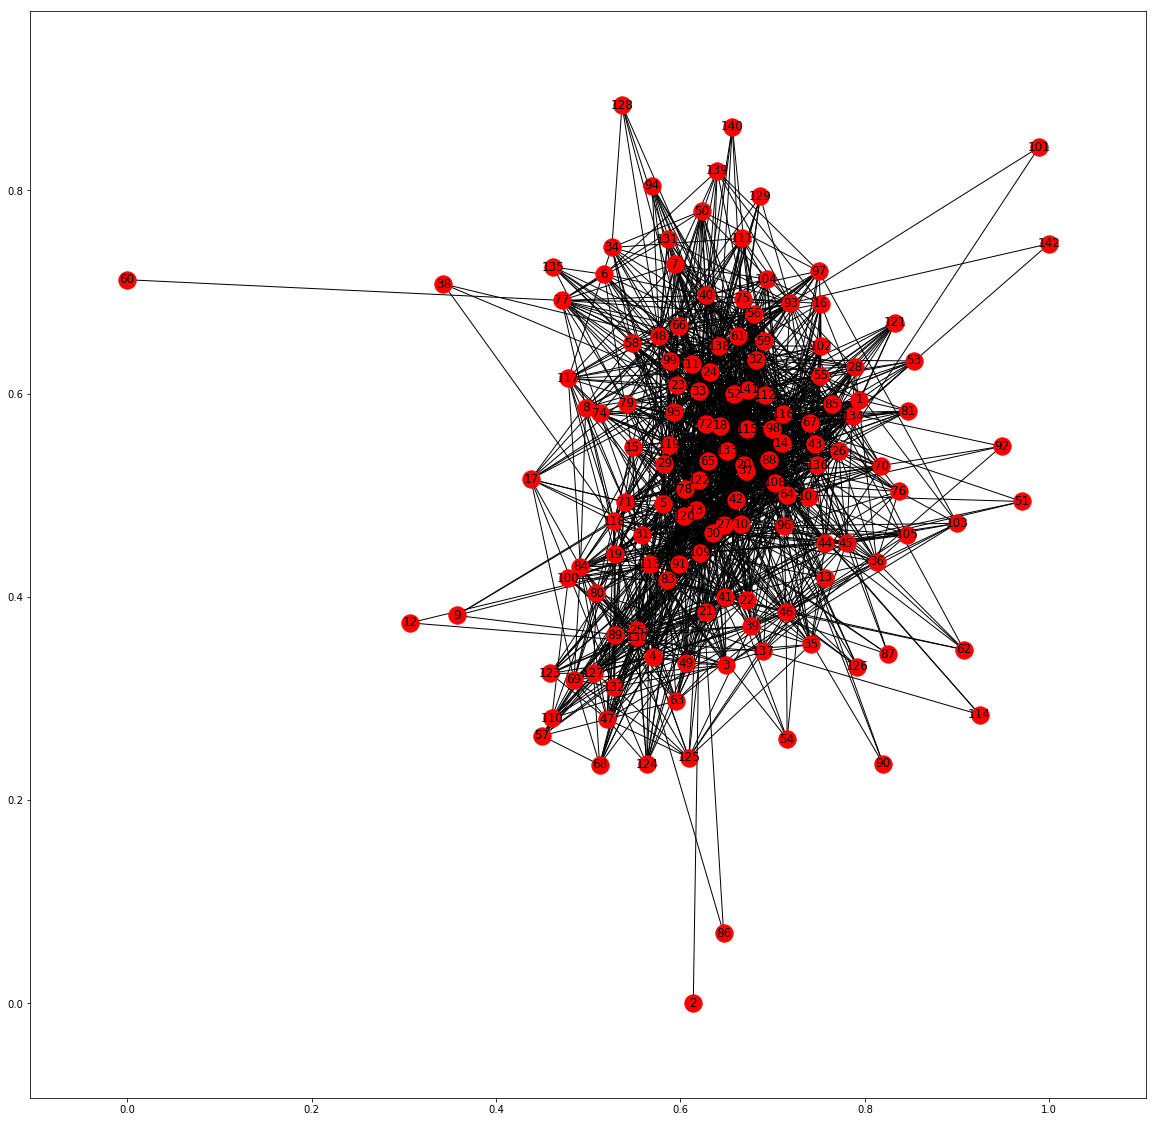

[(1, 133), (1, 136), (1, 10), (1, 14), (1, 16), (1, 18), (1, 20), (1, 32), (1, 37), (1, 42), (1, 43), (1, 53), (1, 55), (1, 64), (1, 67), (1, 72), (1, 73), (1, 81), (1, 88), (1, 98), (1, 107), (1, 108), (1, 115), (1, 116), (1, 119), (1, 121), (2, 109), (3, 65), (3, 130), (3, 91), (3, 132), (3, 69), (3, 113), (3, 73), (3, 103), (3, 109), (3, 49), (3, 30), (3, 118), (3, 25), (3, 120), (3, 36), (3, 27), (3, 4), (3, 5), (4, 130), (4, 132), (4, 5), (4, 21), (4, 22), (4, 25), (4, 27), (4, 29), (4, 30), (4, 31), (4, 35), (4, 39), (4, 42), (4, 46), (4, 47), (4, 49), (4, 57), (4, 63), (4, 68), (4, 69), (4, 73), (4, 78), (4, 80), (4, 83), (4, 84), (4, 89), (4, 91), (4, 100), (4, 109), (4, 110), (4, 113), (4, 120), (4, 123), (4, 124), (4, 125), (4, 127), (5, 133), (5, 10), (5, 18), (5, 24), (5, 25), (5, 27), (5, 30), (5, 31), (5, 33), (5, 42), (5, 45), (5, 48), (5, 49), (5, 52), (5, 55), (5, 138), (5, 66), (5, 67), (5, 72), (5, 73), (5, 88), (5, 91), (5, 96), (5, 98), (5, 99), (5, 100), (5, 108),

In [42]:
for G,name in single_contact_networks_list:
    draw_graph_helper(G,"spring")
    print G.edges()
    print name,list_local_bridges(G)

In [ ]:
import threading
THREADS = 8
closure_param = 0.05
steps = 3
committee_sz = 3
committees = comb(G.nodes(),committee_sz)
num_committees = len(committees)
committees_split = []

def get_max_committee(G,t_remaining)

    if (t_remaining == 0):
        max_covg = -1
        max_committee = None
        #Get committee with highest coverage
        for c in committees:
            G_next = committee_closure_augmentation(construct_awareness_from_contact_graph(G),c,closure_param)
            covg = get_exp_coverage(G_next,G.nodes(),c)
            if (covg > max_covg):
                max_covg = covg
                max_committee = c
            
                

def thread_committee_selection(first_committees,t):
    print "Starting committee selection thread"
    for c in first_committees:
        G_next = committee_closure_augmentation(construct_awareness_from_contact_graph(G),c,closure_param)
        ending_coverage,ending_committees = get_max_committee(G_next,t-1)
        
    print "Ending committee selection thread"
    

for i in range(THREADS):
    if (i < THREADS-1):
        committees_split.append(committees[i*(num_committees/THREADS):(i+1)*(num_committees/THREADS)])
    else:
        committeess_split.append(committees[i*(num_committees/THREADS):])

for i in range(THREAD):
    threading.Thread(target=thread_committee_selection,kwarg={first_committees=committees_split[i],t=steps}).start()
    

In [73]:
import threading
G_global = None
committees_global = None
committee_sz = None
closure_param_global = None

def init_opt_committee_selection(G,t,k,closure_param,threads):
    committees_split = []
    committees = [i for i in comb(G.nodes(),k)]
    print "Committees are ",committees
    committees_global = copy.deepcopy(committees)
    print "Committees are ",committees_global
    num_committees = len(committees)
    G_global = G
    committee_sz = k
    closure_param_global = closure_param
    
    for i in range(threads):
        if (i < threads-1):
            committees_split.append(committees[i*(num_committees/threads):(i+1)*(num_committees/threads)])
        else:
            committees_split.append(committees[i*(num_committees/threads):])

    for i in range(threads):
        print "Starting thread ",i
        threading.Thread(target=thread_opt_committee_selection,args=(G_global,committees_split[i],i,)).start()
        
    
def thread_opt_committee_selection(G,committees,thread_num):
    for c in committees:
        val,com = rec_opt_committee_selection(committee_closure_augmentation(construct_awareness_from_contact_graph(G),c,closure_param_global),t-1)
        if (val > max_val):
            max_val = val
            max_com = [c,com]
            
    print "Max for thread %i is" % thread_num,max_val,max_com
    
def rec_opt_committee_selection(G,t):
   
    #rec step
    if (t > 0):
        max_val = -1
        max_com = []
        for c in committees_global:
            val,com = rec_opt_committee_selection(committee_closure_augmentation(construct_awareness_from_contact_graph(G),c,closure_param_global),t-1)
            if (val > max_val):
                max_val = val
                max_com = [c,com]
        
        
    if (t==0):
        #get opt solution for last 
        max_com,max_val = greedy_expected_max_coverage_set(construct_awareness_from_contact_graph(G),committee_sz,committee_sz)
        
    return max_val,max_com
       

In [74]:
G = get_undirected_ER_graph(8,0.5)
t = 2
k = 2
closure_param = 0.1

init_opt_committee_selection(G,t,k,closure_param,7)

Committees are  [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (3, 4), (3, 5), (3, 6), (3, 7), (4, 5), (4, 6), (4, 7), (5, 6), (5, 7), (6, 7)]
Committees are Committees are   NoneCommittees are [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (3, 4), (3, 5), (3, 6), (3, 7), (4, 5), (4, 6), (4, 7), (5, 6), (5, 7), (6, 7)]
 
NoneCommittees are Starting thread 
 Committees are  None Committees are 0Committees are 
None Committees are 
  
NoneStarting thread NoneNone
 

1
Starting thread  2
Starting thread  3
Starting thread  4
Starting thread  5
Starting thread  6


Exception in thread Thread-26:
Traceback (most recent call last):
  File "/home/alex/anaconda2/lib/python2.7/threading.py", line 801, in __bootstrap_inner
    self.run()
  File "/home/alex/anaconda2/lib/python2.7/threading.py", line 754, in run
    self.__target(*self.__args, **self.__kwargs)
  File "<ipython-input-73-2883026e202e>", line 31, in thread_opt_committee_selection
    val,com = rec_opt_committee_selection(committee_closure_augmentation(construct_awareness_from_contact_graph(G),c,closure_param_global),t-1)
  File "<ipython-input-73-2883026e202e>", line 44, in rec_opt_committee_selection
    for c in committees_global:
TypeError: 'NoneType' object is not iterable

Exception in thread Thread-27:
Traceback (most recent call last):
  File "/home/alex/anaconda2/lib/python2.7/threading.py", line 801, in __bootstrap_inner
    self.run()
  File "/home/alex/anaconda2/lib/python2.7/threading.py", line 754, in run
    self.__target(*self.__args, **self.__kwargs)
  File "<ipython-input-